In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mosfit
import time
import sys

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
#import sqlalchemy 
import random
import json
from collections import OrderedDict
from scipy import interpolate
# from dust_extinction.averages import GCC09_MWAvg
# from dustmaps.sfd import SFDQuery
from astropy.coordinates import SkyCoord
from astropy import units as u
import os

In [3]:
# !mosfit -m tde -e ./astrocatalogs/tde-1980-2025/J030257.json --extra-bands u g r i z y
directory = '/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13'
meta_data = pd.read_csv(directory+"/meta_data_panda.csv")
meta_data

Unnamed: 0       bhmass  stellar_mass  scaled_b  redshift    label
0               0     100000.0           0.3       0.0      0.01      0.0
1               1     100000.0           0.3       0.0      0.12      1.0
2               2     100000.0           0.3       0.0      0.23      2.0
3               3     100000.0           0.3       0.0      0.34      3.0
4               4     100000.0           0.3       0.0      0.45      4.0
...           ...          ...           ...       ...       ...      ...
23995       23995  100000000.0           1.0       2.0      0.56  23995.0
23996       23996  100000000.0           1.0       2.0      0.67  23996.0
23997       23997  100000000.0           1.0       2.0      0.78  23997.0
23998       23998  100000000.0           1.0       2.0      0.89  23998.0
23999       23999  100000000.0           1.0       2.0      1.00  23999.0

[24000 rows x 6 columns]

In [4]:

#Define the light curve class
class LightCurve():
    """
    A basic transient model
    """

    def __init__(self, times, mags, true_mags, filters, snrs, err, mwebv = 0, mosfitphase=None): #theta?
        """
        Parameters:
        ----------
        ...

        """
        self.times = times
        self.mags = mags
        self.true_mags = true_mags
        self.filters = filters
        self.snrs = snrs
        self.errs = err
        #self.theta = theta
        self.mwebv = mwebv
        self.mosfitphase=mosfitphase

    def get_df(self):
        ## Return a DataFrame withe time,mag,filter,snr,err
        #print(self.mags)
        #print(self.true_mags)
        df_lc = pd.DataFrame({"timeMJD":self.times, "mags":self.mags, "truemags":self.true_mags,
                              "errors":self.errs, "SNRs":self.snrs,
                              "filter":self.filters})
        if self.mosfitphase is not None:
            df_lc['MOSFITday'] = self.mosfitphase
            
        return df_lc
        



opsim_file = '/d6/CAC/gcontardo/Data/baseline_v4.0_10yrs.db'

opsim = os.path.basename(opsim_file).replace('.db','')
print(opsim)

# This reads in the OpSim File
# This file is a database containing many,many pointings of LSST
conn = sqlite3.connect(opsim_file)    

#Now in order to read in pandas dataframe we need to know table name
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';") 
#proposalId
df_v4 = pd.read_sql_query('SELECT fieldRA, fieldDec, seeingFwhmEff, observationStartMJD, filter, fiveSigmaDepth, skyBrightness  FROM observations', conn)
conn.close()

baseline_v4.0_10yrs


In [5]:
def get_MOSIFT(json_file):
    ## Utility function that return a list of times and a dictionnary of the list of mags (keys are the bands) 
    ## 
    band_list_cln = ['u','g','r','i','z','y']
    
    max_phase=1000
    
    #print(tmin, tmax)
    with open(json_file, 'r', encoding = 'utf-8') as f:
        data = json.loads(f.read())
        if 'name' not in data:
            data = data[list(data.keys())[0]]
    
    photo = data['photometry']
    model = data['models'][0]
    
    band_attr = ['band', 'instrument', 'telescope', 'system', 'bandset']
    band_list2 = list(set([tuple(x.get(y, '')
                                for y in band_attr) for x in photo
                                if 'band' in x and 'magnitude' in x]))
    
    ## Still not too sure why I have two realizations when I run mosfit but?? 
    ## TODO Check how many real we got for all the TDEs generated
    realiza = []
    for x in photo:
        realiza.append(x['realization'])
    realiza = np.unique(realiza)
    
    rea = realiza[0] ## 
    
    times = {b:[] for b in band_list_cln} # 
    magsMOS = {b:[] for b in band_list_cln}
    for x in photo:
        if x['realization']==rea:
            times[x['band']].append(float(x['time']))
            magsMOS[x['band']].append(float(x['magnitude']))
    
    
    # Have to cheat for the times...
    for b in band_list_cln:
        times[b] = np.arange(max_phase)
    return times['u'], magsMOS

In [6]:
def get_MOSIFT_reals_errors(json_file):
    ## Utility function that return a dictionnary with realizations from MOSFIT (it returns 2 for some reasons) 
    ## where each elem has a list of time, the mags for the bands (as a dict) and errors for the bands (as a dict)
    band_list_cln = ['u','g','r','i','z','y']
    
    max_phase=1000
    
    #print(tmin, tmax)
    with open(json_file, 'r', encoding = 'utf-8') as f:
        data = json.loads(f.read())
        if 'name' not in data:
            data = data[list(data.keys())[0]]
    
    photo = data['photometry']
    model = data['models'][0]
    
    band_attr = ['band', 'instrument', 'telescope', 'system', 'bandset']
    band_list2 = list(set([tuple(x.get(y, '')
                                for y in band_attr) for x in photo
                                if 'band' in x and 'magnitude' in x]))
    
    ## Still not too sure why I have two realizations when I run mosfit but?? 
    ## TODO Check how many real we got for all the TDEs generated
    realiza = []
    for x in photo:
        realiza.append(x['realization'])
    realiza = np.unique(realiza)
    
    rea_dic = {}
    for rea in realiza:
        times = {b:[] for b in band_list_cln} # 
        magsMOS = {b:[] for b in band_list_cln}
        emagsMOS = {b:[] for b in band_list_cln}
        for x in photo:
            if x['realization']==rea:
                times[x['band']].append(float(x['time']))
                magsMOS[x['band']].append(float(x['magnitude']))
                emagsMOS[x['band']].append(float(x['e_magnitude']))
        
        # Have to cheat for the times...
        for b in band_list_cln:
            times[b] = np.arange(max_phase)
        rea_dic[rea] = {'time':times['u'], 'mags':magsMOS, 'e_mags': emagsMOS}
    return rea_dic

In [7]:
def get_MOSIFT_reals_errors_addnoise(json_file, shave_time=0):
    ## Utility function that return a dictionnary with realizations from MOSFIT (it returns 2 for some reasons) 
    ## where each elem has a list of time, the mags for the bands (as a dict) and errors for the bands (as a dict)
    band_list_cln = ['u','g','r','i','z','y']
    
    max_phase=1000
    
    #print(tmin, tmax)
    with open(json_file, 'r', encoding = 'utf-8') as f:
        data = json.loads(f.read())
        if 'name' not in data:
            data = data[list(data.keys())[0]]
    
    photo = data['photometry']
    model = data['models'][0]
    
    band_attr = ['band', 'instrument', 'telescope', 'system', 'bandset']
    band_list2 = list(set([tuple(x.get(y, '')
                                for y in band_attr) for x in photo
                                if 'band' in x and 'magnitude' in x]))
    
    ## Still not too sure why I have two realizations when I run mosfit but?? 
    ## TODO Check how many real we got for all the TDEs generated
    realiza = []
    for x in photo:
        realiza.append(x['realization'])
    realiza = np.unique(realiza)
    
    rea_dic = {}
    for rea in realiza:
        times = {b:[] for b in band_list_cln} # 
        magsMOS = {b:[] for b in band_list_cln}
        emagsMOS = {b:[] for b in band_list_cln}
        noisymagsMOS = {b:[] for b in band_list_cln}
        for x in photo:
            if x['realization']==rea:
                if float(x['time'])>=shave_time:
                    times[x['band']].append(float(x['time']))
                    magsMOS[x['band']].append(float(x['magnitude']))
                    emagsMOS[x['band']].append(float(x['e_magnitude']))
                    noisymagsMOS[x['band']].append(float(x['magnitude']) +  np.random.normal(0, float(x['e_magnitude'])))
        
        # Have to cheat for the times...
        for b in band_list_cln:
            times[b] = np.arange(len(times[b]))

            
        rea_dic[rea] = {'time':times['u'], 'mags':magsMOS, 'e_mags': emagsMOS, 'noisymags': noisymagsMOS}
    return rea_dic

In [8]:
# band_list_cln = ['u','g','r','i','z','y']

# max_phase=1000
# json_file = f"/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_{95}.json"
# reas = get_MOSIFT_reals_errors_addnoise(json_file)

# for k in reas.keys():
#     plt.figure()

#     for b in ['u','g', 'r']:
#         plt.errorbar(reas[k]['time'], reas[k]['mags'][b], yerr=reas[k]['e_mags'][b], label=b)
    
#     plt.gca().invert_yaxis()
#     plt.show()

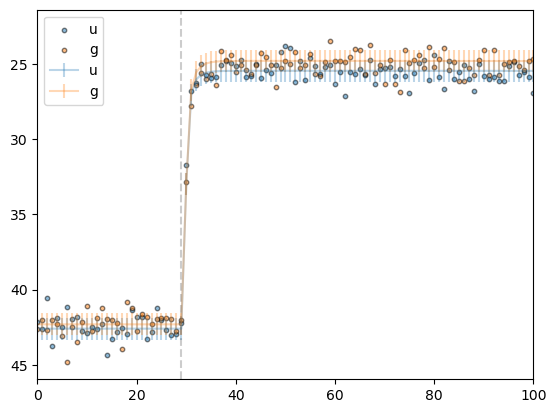

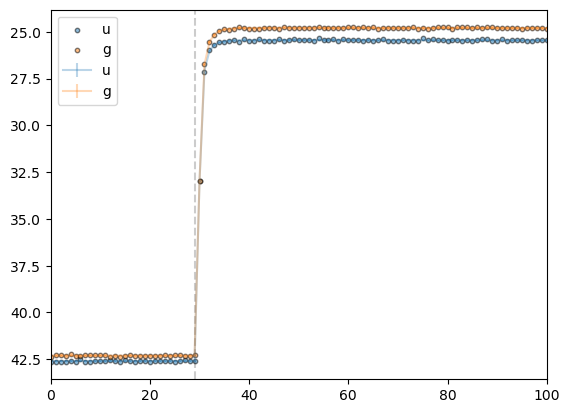

In [8]:
band_list_cln = ['u','g','r','i','z','y']

max_phase=1000
json_file = f"/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_{95}.json"
reas = get_MOSIFT_reals_errors_addnoise(json_file, shave_time=120)

for k in reas.keys():
    plt.figure()

    for b in ['u','g']:#, 'r']:
        plt.errorbar(reas[k]['time'], reas[k]['mags'][b], yerr=reas[k]['e_mags'][b], label=b, alpha=.3)
        plt.scatter(reas[k]['time'], reas[k]['noisymags'][b], label=b, s=10, edgecolors='k', alpha=.5)
    plt.legend()
    plt.gca().invert_yaxis()
    plt.xlim(0,100)
    
    plt.axvline(29, color='k', ls='--', alpha=.2)
    plt.show()

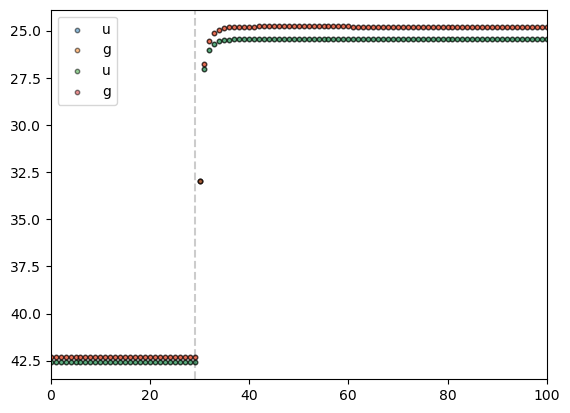

In [9]:
band_list_cln = ['u','g','r','i','z','y']

max_phase=1000
json_file = f"/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_{95}.json"
reas = get_MOSIFT_reals_errors_addnoise(json_file, shave_time=120)

for k in reas.keys():
    

    for b in ['u','g']:#, 'r']:
        #plt.errorbar(reas[k]['time'], reas[k]['mags'][b], yerr=reas[k]['e_mags'][b], label=b, alpha=.3)
        plt.scatter(reas[k]['time'], reas[k]['mags'][b], label=b, s=10, edgecolors='k', alpha=.5)
plt.legend()
plt.gca().invert_yaxis()
plt.xlim(0,100)

plt.axvline(29, color='k', ls='--', alpha=.2)
plt.show()

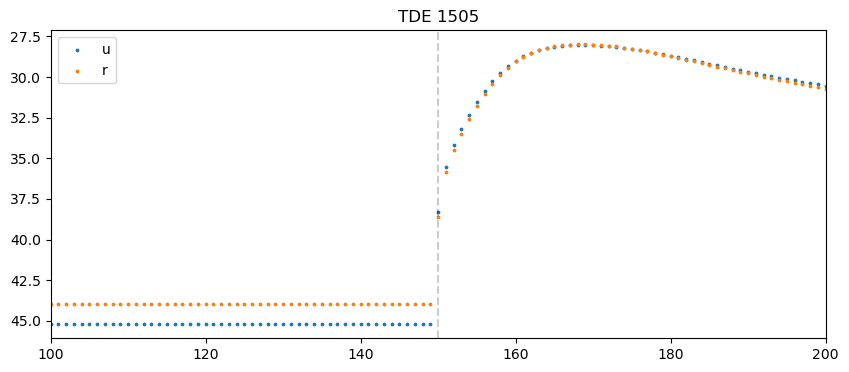

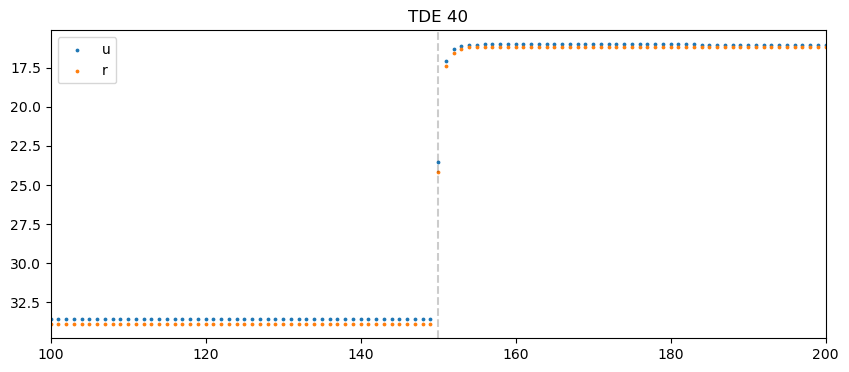

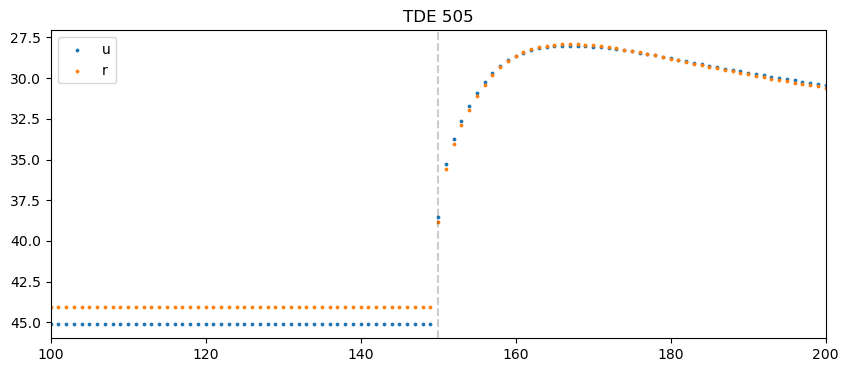

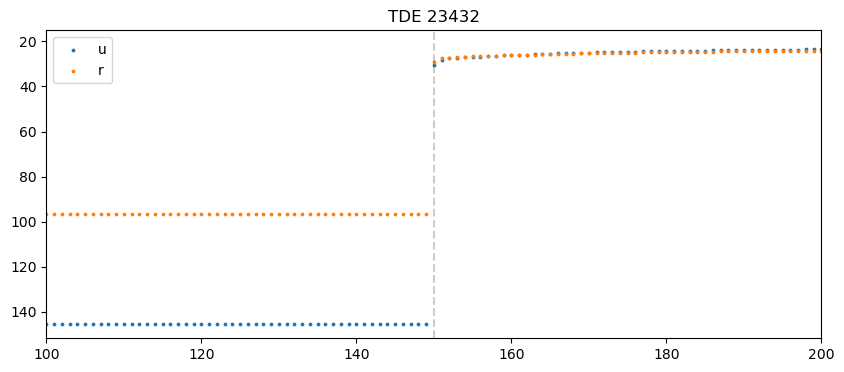

In [11]:

for idx in [1505, 40, 505, 23432]:
    json_Tde = f"/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_{idx}.json"
    times,mags = get_MOSIFT(json_Tde)
    
    plt.figure(figsize=(10,4))
    plt.axvline(150, color='k', ls='--', alpha=.2)
    plt.scatter(times, mags['u'], label='u', s=3)
    plt.scatter(times, mags['r'], label='r', s=3)
    plt.legend()
    plt.gca().invert_yaxis()
    plt.title(f"TDE {idx}")
    plt.xlim(100,200)

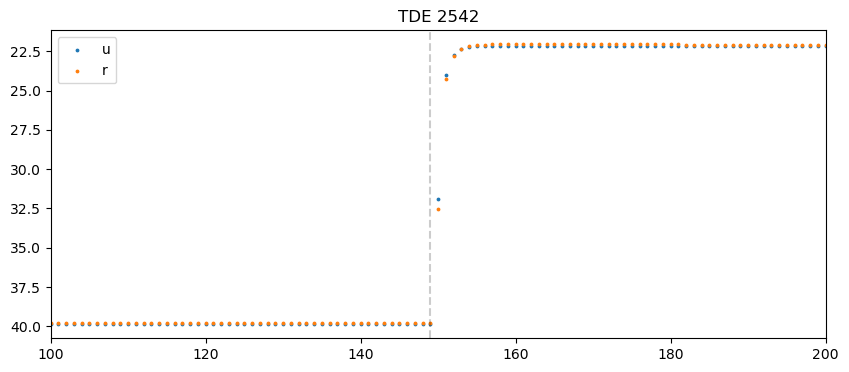

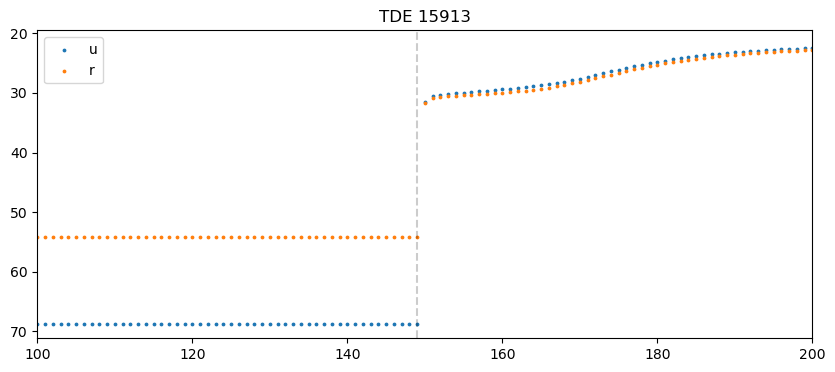

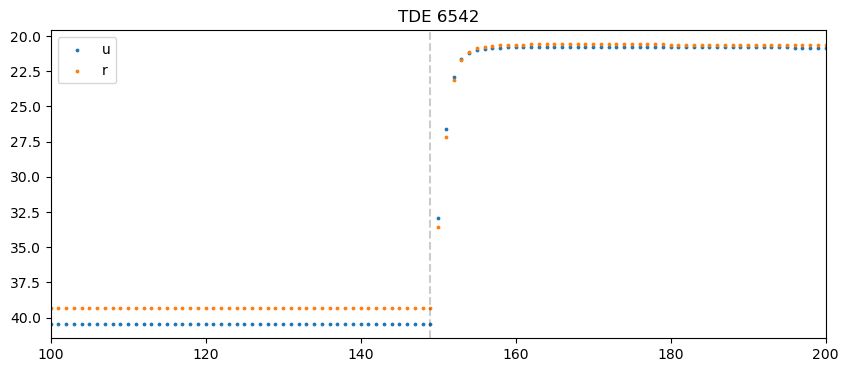

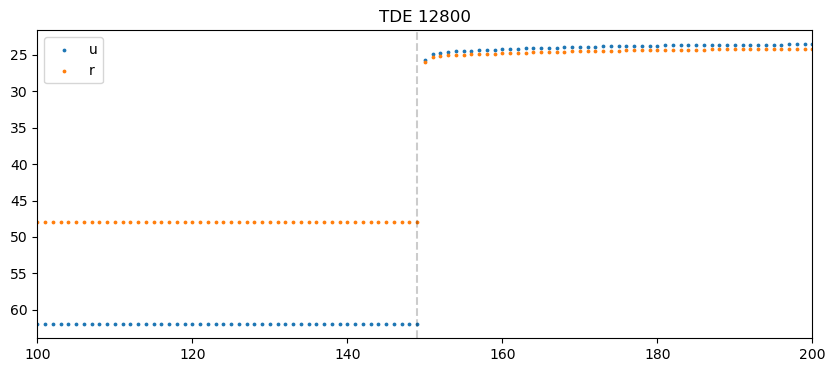

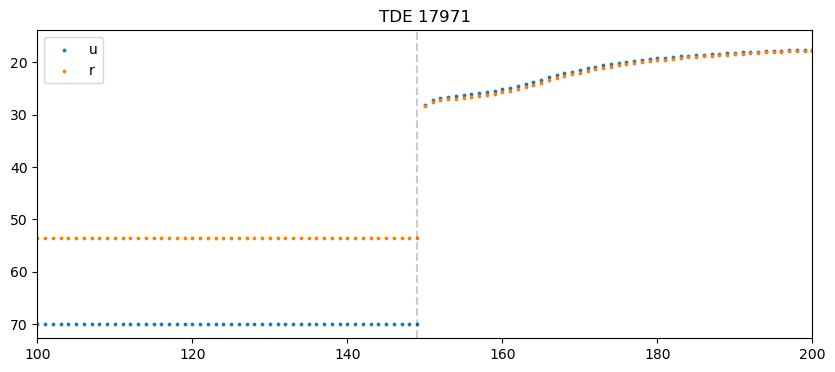

In [18]:

for i in range(5):
    idx = np.random.randint(0,24000)
    json_Tde = f"/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_{idx}.json"
    times,mags = get_MOSIFT(json_Tde)

    while np.min(mags['u'])>24:
        idx = np.random.randint(0,24000)
        json_Tde = f"/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_{idx}.json"
        times,mags = get_MOSIFT(json_Tde)
        
    plt.figure(figsize=(10,4))
    plt.axvline(149, color='k', ls='--', alpha=.2)
    plt.scatter(times, mags['u'], label='u', s=3)
    plt.scatter(times, mags['r'], label='r', s=3)
    plt.legend()
    plt.gca().invert_yaxis()
    plt.title(f"TDE {idx}")
    plt.xlim(100,200)

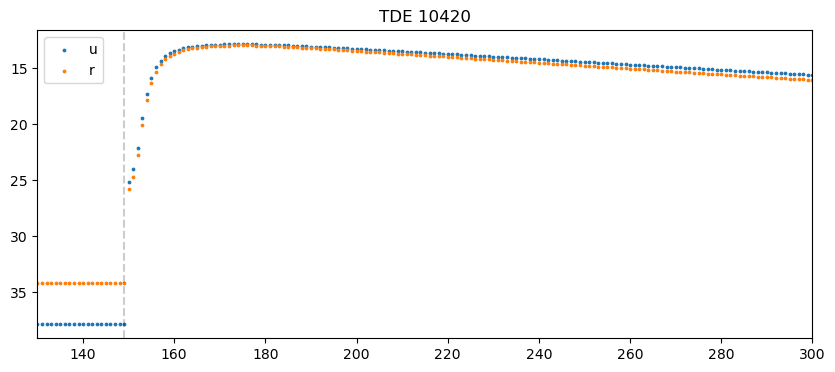

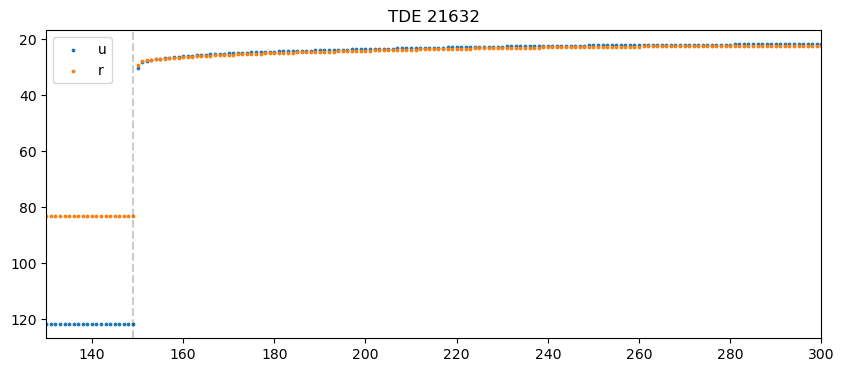

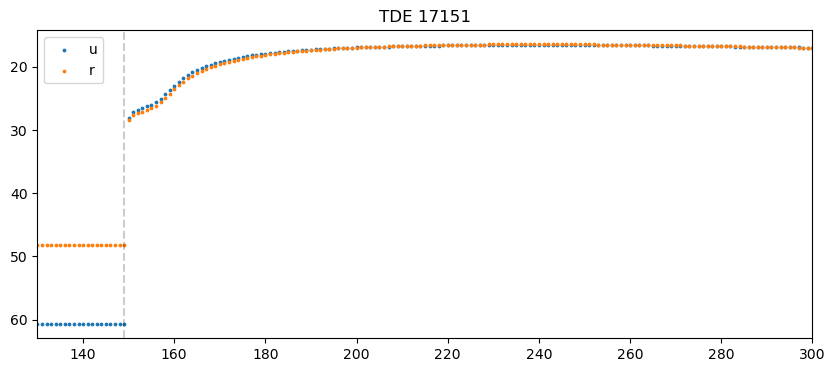

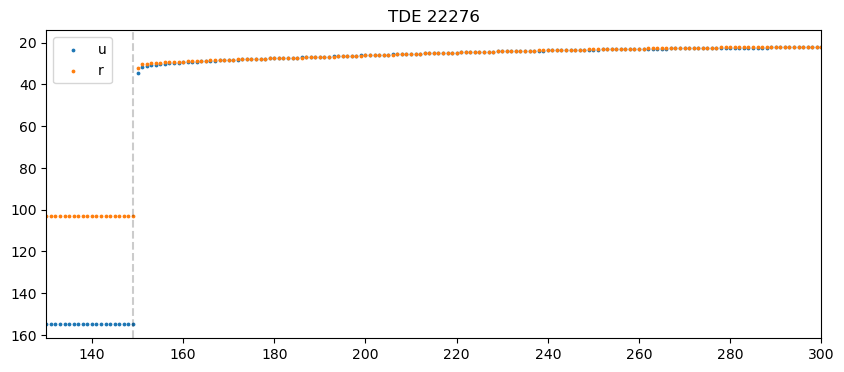

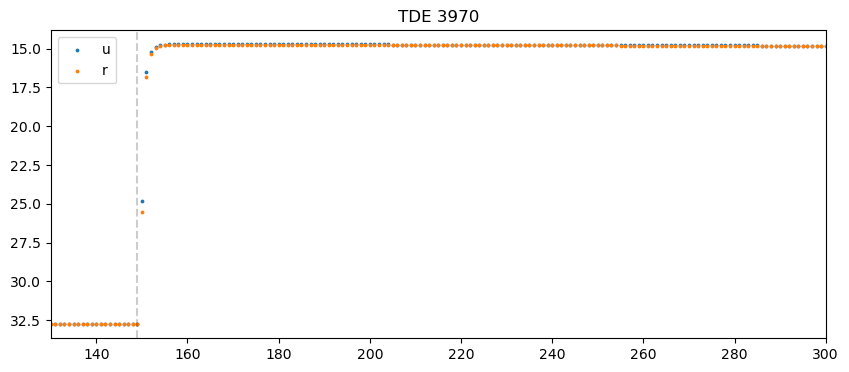

In [19]:

for i in range(5):
    idx = np.random.randint(0,24000)
    json_Tde = f"/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_{idx}.json"
    times,mags = get_MOSIFT(json_Tde)

    while np.min(mags['u'])>24:
        idx = np.random.randint(0,24000)
        json_Tde = f"/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_{idx}.json"
        times,mags = get_MOSIFT(json_Tde)
        
    plt.figure(figsize=(10,4))
    plt.axvline(149, color='k', ls='--', alpha=.2)
    plt.scatter(times, mags['u'], label='u', s=3)
    plt.scatter(times, mags['r'], label='r', s=3)
    plt.legend()
    plt.gca().invert_yaxis()
    plt.title(f"TDE {idx}")
    plt.xlim(130,300)
    

In [8]:
dir_lsst = "/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/lsst_synth_mosfitdays/"
idx=40
dflc= pd.read_csv(dir_lsst+f"synth_tde_{idx}.csv")
dflc

Unnamed: 0       timeMJD         mags   truemags       errors  \
0             0  60823.428577   506.855136  34.127337  3324.328794   
1             1  60830.322887   368.872284  33.702240  1468.371617   
2             2  60830.347903 -1297.443072  33.907119  2256.963832   
3             3  60830.431383  4561.976482  34.127337  2807.179637   
4             4  60854.425257 -1970.995411  33.907119  2138.935424   
..          ...           ...          ...        ...          ...   
229         229  61776.048102    18.332453  18.338455     0.006170   
230         230  61776.048340    18.347539  18.338455     0.006321   
231         231  61776.051221    18.337488  18.338455     0.004417   
232         232  61776.051458    18.342146  18.338455     0.004534   
233         233  61776.054339    18.338811  18.338455     0.004572   

           SNRs filter  MOSFITday  
0      0.000328      i        3.0  
1      0.000742      g       10.0  
2      0.000483      r       10.0  
3      0.000388      i       10.0  
4      0.000510      r       34.0  
..          ...    ...        ...  
229  176.669711      i      956.0  
230  172.453884      i      956.0  
231  246.776264      i      956.0  
232  240.384046      i      956.0  
233  238.409768      i      956.0  

[234 rows x 8 columns]

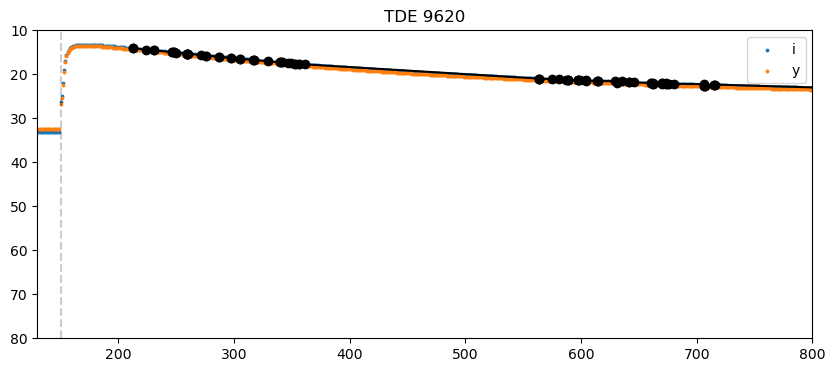

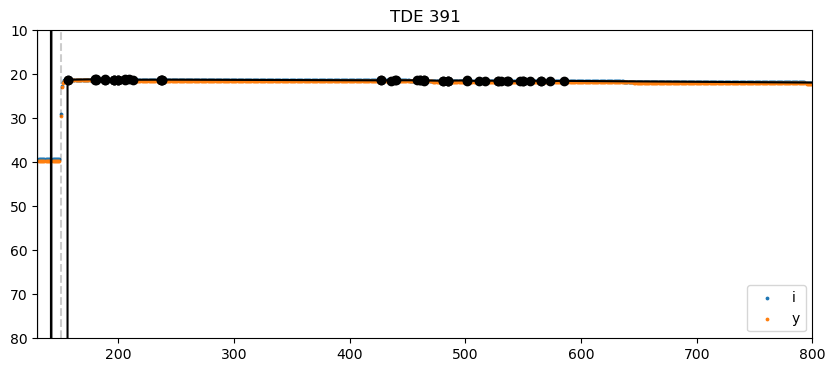

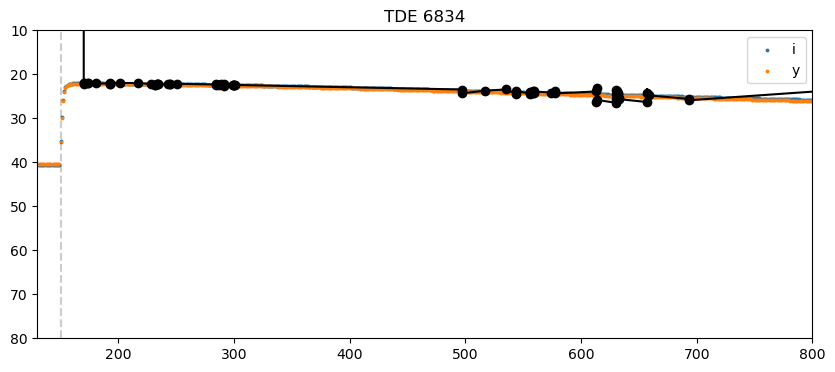

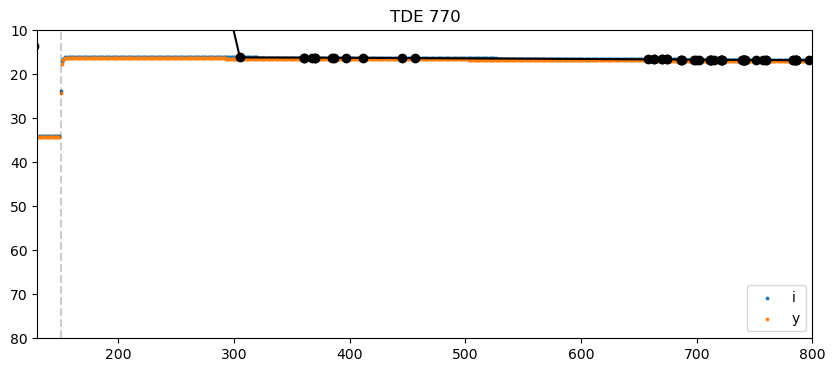

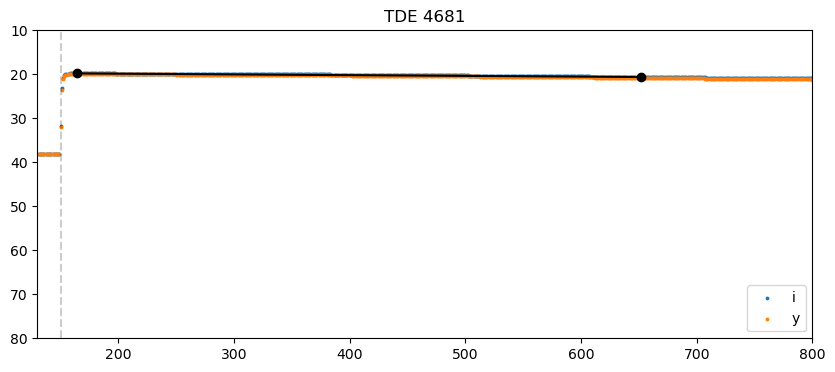

In [21]:

for i in range(5):
    idx = np.random.randint(0,10000)
    json_Tde = f"/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_{idx}.json"
    times,mags = get_MOSIFT(json_Tde)
    
    dflc= pd.read_csv(dir_lsst+f"synth_tde_{idx}.csv")

    while np.min(mags['u'])>24:
        idx = np.random.randint(0,10000)
        json_Tde = f"/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_{idx}.json"
        times,mags = get_MOSIFT(json_Tde)
        dflc= pd.read_csv(dir_lsst+f"synth_tde_{idx}.csv")

        
    plt.figure(figsize=(10,4))
    plt.axvline(150, color='k', ls='--', alpha=.2)
    plt.scatter(times, mags['i'], label='i', s=3)
    plt.scatter(times, mags['y'], label='y', s=3)
    
    mask = dflc['filter']=='i'
    plt.errorbar(dflc['MOSFITday'][mask], dflc['mags'][mask], yerr=dflc['errors'][mask], color='k',
                marker='o')
    
    plt.legend()
    plt.gca().invert_yaxis()
    plt.title(f"TDE {idx}")
    plt.xlim(130,800)
    plt.ylim(80,10)

In [22]:
pd.read_csv(dir_lsst+f"synth_tde_{5553}.csv")

Unnamed: 0       timeMJD          mags   truemags        errors  \
0             0  61244.427580 -2.317561e+05  40.023457  2.434470e+06   
1             1  61244.427818  5.820762e+05  40.023457  2.482420e+06   
2             2  61244.430698  1.224101e+06  40.023457  2.102504e+06   
3             3  61244.430936  3.363662e+05  40.023457  2.161702e+06   
4             4  61244.433816 -1.192232e+05  40.023457  2.231465e+06   
..          ...           ...           ...        ...           ...   
249         249  62139.265381  2.287352e+01  23.258448  3.680947e-01   
250         250  62142.222805  2.314418e+01  23.264050  3.112788e-01   
251         251  62142.246851  2.311660e+01  23.374714  6.917300e-01   
252         252  62150.169599  2.304472e+01  23.007021  8.361152e-02   
253         253  62150.193863  2.303427e+01  23.069290  1.246643e-01   

             SNRs filter  MOSFITday  
0    4.477361e-07      i       85.0  
1    4.390877e-07      i       85.0  
2    5.184295e-07      i       85.0  
3    5.042324e-07      i       85.0  
4    4.884684e-07      i       85.0  
..            ...    ...        ...  
249  2.961194e+00      z      980.0  
250  3.501684e+00      z      983.0  
251  1.575759e+00      y      983.0  
252  1.303648e+01      g      991.0  
253  8.743479e+00      r      991.0  

[254 rows x 8 columns]

## Estimation of average observation-rate during rise time

### First, compute the distribution of the rise-time for our dataset WHICH IS NOT REPRESENTATIVE OF TDE POPULATION

In [37]:
df_tdes = pd.read_csv("/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/meta_data_panda.csv")


In [10]:

# rise_days = []
# for i in range(len(df_tdes)):
#     json_Tde = f"/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_{int(df_tdes["label"].iloc[i])}.json"
#     if i % 1000 == 0:
#         print(json_Tde)

#     try:
#         times, magsMOS = get_MOSIFT(json_Tde)
#         ## Approximate as which days has the peak in mags? Say for band 'u'?
#         rise_days.append(times[np.argmin(magsMOS['u'])] - 149)
#     except FileNotFoundError:
#         print(f"{i} is missing?")
        
# rise_days = np.array(rise_days)

In [ ]:
plt.hist(rise_days[rise_days<50]);
#plt.yscale('log')

In [11]:


opsim_file = '/d6/CAC/gcontardo/Data/baseline_v4.0_10yrs.db'

opsim = os.path.basename(opsim_file).replace('.db','')
print(opsim)

# This reads in the OpSim File
# This file is a database containing many,many pointings of LSST
conn = sqlite3.connect(opsim_file)    

#Now in order to read in pandas dataframe we need to know table name
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';") 
#proposalId
df_v4 = pd.read_sql_query('SELECT fieldRA, fieldDec, seeingFwhmEff, observationStartMJD, filter, fiveSigmaDepth, skyBrightness  FROM observations', conn)
conn.close()

baseline_v4.0_10yrs


In [12]:
mypath_filters = '/d6/CAC/gcontardo/Data/filters/'

filter_path = mypath_filters+(f'LSST_LSST.y.dat')

c_AAs = 2.998e18  # Speed of light in Ångströms per second

band_list = ['u','g','r','i','z','y']
band_wvs = np.asarray([3751.36, 4741.64, 6173.23, 7501.62, 8679.19, 9711.53]) # in angstrom


# This is all to just set up the OpSim Equations
function_list = np.asarray([])
filter_list = np.asarray([])
for band in band_list:
	filter_path = mypath_filters+(f'LSST_LSST.{band}.dat')
	blah = np.loadtxt(filter_path)
	function_list = np.append(function_list,np.trapz(blah[:,1]/blah[:,0],blah[:,0]))
	filter_list = np.append(filter_list,interpolate.interp1d(blah[:,0],blah[:,1],bounds_error=False,fill_value=0.0))
func_dict = {}
bands_and_func = zip(band_list, function_list)
for band, func in bands_and_func:
	func_dict[band] = func
filt_dict = {}
bands_and_filts = zip(band_list, filter_list)
for band, func in bands_and_filts:
	filt_dict[band] = func

# 
keep_LCs = True
tmin = np.min(df_v4['observationStartMJD'])
tmax = np.min(df_v4['observationStartMJD'])+ 365


In [13]:
def get_rise_obs(json_file, df, tmin, tmax, min_datapt=1, nb_opsim=5, shave_time=0):

    
    ## So I pick a lightcurve, and put it somewhere on the sky
    band_list_cln = ['u','g','r','i','z','y']
    
    max_phase=1000 - shave_time
    
    #print(tmin, tmax)
    with open(json_file, 'r', encoding = 'utf-8') as f:
        data = json.loads(f.read())
        if 'name' not in data:
            data = data[list(data.keys())[0]]
    
    photo = data['photometry']
    model = data['models'][0]
    
    band_attr = ['band', 'instrument', 'telescope', 'system', 'bandset']
    band_list2 = list(set([tuple(x.get(y, '')
                                for y in band_attr) for x in photo
                                if 'band' in x and 'magnitude' in x]))
    
    ## 
    ## TODO Check how many real we got for all the TDEs generated, is it always...2?
    realiza = []
    for x in photo:
        realiza.append(x['realization'])
    realiza = np.unique(realiza)
    
    rea = realiza[0] ## 
    
    times = {b:[] for b in band_list_cln} # 
    truemagsMOS = {b:[] for b in band_list_cln}
    emagsMOS = {b:[] for b in band_list_cln}
    noisymagsMOS = {b:[] for b in band_list_cln}
    
    for x in photo:
        if x['realization']==rea:
            ### This removes some of the "useless" days before the start of the even, if we want that. 
            ### 
            if float(x['time'])>=shave_time:
                times[x['band']].append(float(x['time']))
                truemagsMOS[x['band']].append(float(x['magnitude']))
                emagsMOS[x['band']].append(float(x['e_magnitude']))
                noisymagsMOS[x['band']].append(float(x['magnitude']) +  np.random.normal(0, float(x['e_magnitude'])))
    
    # Have to cheat for the times...
    for b in band_list_cln:
        times[b] = np.arange(len(times[b]))


    ##Figure out the peak day... Let's pick a band to estimate it
    peak_day = times['u'][np.argmin(truemagsMOS['u'])]

    rise_day = 149 - shave_time
    
    
    # Choose a random start time for the event
    # Everything is in MJD 
    # Let's approximate also all date as int(MJD)

    obs_rises = []
    for nops in range(nb_opsim):
        len_db = 0
        
        ## Ensure we have at least min_datapt (right now, anything > 0 flies)
        while len_db<min_datapt: 
        
            start_mjd = random.uniform(tmin, tmax)
            #max_phase = np.max(times['u'])
            
            shifted_times = np.array(times['u']) + np.floor(start_mjd)
            #shifted_times = np.floor(shifted_times).astype('int')
            
            
            ## Put it Somwhere on the sky:
            ## Ideally this should be a location of a galaxy from CatSIM but well...
            
            ra = np.random.uniform(0, 360)
            dec = np.arcsin(np.random.uniform(-1, 1)) * 180 / np.pi
            
            # REVERTED BACK TO 3x3 degree
            
            new_db = df.where((np.abs(df['fieldRA'] - ra) < 3) & 
                              (np.abs(df['fieldDec'] - dec) < 3) & 
                              (df['observationStartMJD'] >= start_mjd) & 
                              (df['observationStartMJD'] < shifted_times[-1])).dropna()
            
            len_db = len(new_db)
            
            
            
        new_db['MJDint'] = np.floor(new_db['observationStartMJD'].values).astype(int)
        new_db['deshifted_MJD'] = new_db['MJDint'] - np.floor(start_mjd) ##should be rightish?
    
        nb_obs_rise = len(new_db[(new_db['deshifted_MJD']>=rise_day) & (new_db['deshifted_MJD']<=peak_day)])
        obs_rises.append(nb_obs_rise)
        
    return peak_day-rise_day, obs_rises



In [27]:
json_Tde = f"/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_{int(df_tdes["label"].iloc[20])}.json"
t = time.time()
nbrise_, obsris_ = get_rise_obs(json_Tde,df_v4,tmin,tmax, min_datapt=1, nb_opsim=5, shave_time=120)
print(time.time()-t)


1.0337333679199219


In [27]:
obsris_

[0, 0, 4, 3, 0]

In [28]:
nbrise_

9

In [28]:
### Pick a TDE, generate LSST OpSim and check how many observations we have in the rise
nb_opsim = 5
nbrisedays, obsrises = [], []
ratios_ = []
for _ in range(5000):
    try:
        i = np.random.randint(0, 23999)
        json_Tde = f"/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_{int(df_tdes["label"].iloc[i])}.json"

        nbrise_, obsris_ = get_rise_obs(json_Tde,df_v4,tmin,tmax, min_datapt=10, nb_opsim=nb_opsim, shave_time=120)
        nbrisedays.append(nbrise_)
        obsrises.append(obsris_)
        ratios_.append(np.array(obsris_)/nbrise_)
        
    except FileNotFoundError:
        print(f"{i} is missing")

7737 is missing
20641 is missing
19359 is missing
4586 is missing
13187 is missing
3209 is missing
11175 is missing
1356 is missing
6831 is missing
3209 is missing
1407 is missing
7219 is missing
3414 is missing
20746 is missing
1355 is missing
16534 is missing
20525 is missing
23577 is missing
4082 is missing
16269 is missing
7737 is missing


* Added noise on mosfit, added a "shave_time" so that we remove the first 120 days that are "useless" (no modeling in MOSFIT), so now start of event is at day 29 (or 30 depending how you see things)
* Note: I had ran for the previous and this dataset so that we have a minimum of datapoints in the light-curve (10 observations); it's pretty loose given the light-curves span(ned) 1000 days, BUT this also means we can't use those to state stuff about detection rate truly. It's cheap to rerun if we want to remove that, but for ease right now, it's how it is. Let me know if you have strong opinions (And let's try to not forget this point)
* I have computed some numbers regarding the rise-time and the number of observations we get during it --it's pretty rough, right now I'm just sampling 5000 TDEs randomly on our grid (because I don't know which ones are the most "likely", and parameters of the TDE plays a role on the rise time --although most span between 8 and 50ish days, with a peak around 19 days-- so this is not a representative sample of TDE population so to take with a pinch of salt), and then for each tried 5 random position/time (*however* keeping the "10 observations" minimum along the light-curve, which might _also_ introduce some biase), to get the number of observations we get on the rise only (perhaps slightly overestimated if we're unlucky and it gets the "first" rise data point that isn't really kicked in yet). (On a side note, we could get finner grained number if we think on smaller scale of temporality...). Here are the numbers I get (also: this does not take into account if those datapoints would raise an alert in the broker!)
* For about 30% we have 0 observations on the rise (this ofc being skewed towards event with the shortest rise)

In [37]:
len(obsrises)

4979

In [30]:
obsrises = np.array(obsrises)
ratios_ = np.array(ratios_)
nbrisedays = np.array(nbrisedays)

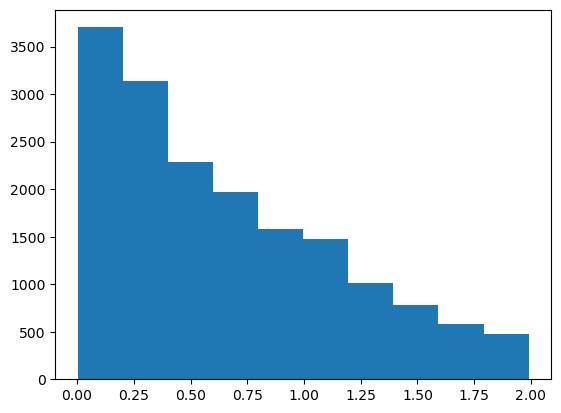

In [31]:
plt.hist(ratios_[(ratios_<2) & (ratios_>0)].reshape(-1));
#plt.yscale('log')

In [32]:
np.sum(obsrises==0)/obsrises.reshape(-1).shape[0]

0.26740309299056036

Text(0, 0.5, 'Number of Observations (any band)')

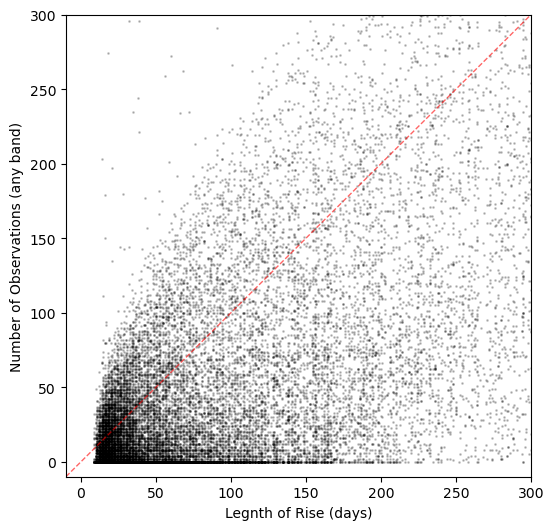

In [68]:
plt.figure(figsize=(6,6))
for i in range(nb_opsim):
    plt.scatter(nbrisedays, obsrises[:,i], c='k', s=1, alpha=.2);

plt.plot([-10,400],[-10,400], ls='--', c='r', alpha=.6, lw=1)
plt.xlim(-10, 300)
plt.ylim(-10,300)
plt.xlabel("Legnth of Rise (days)")
plt.ylabel("Number of Observations (any band)")


Text(0, 0.5, 'Number of Observations (any band)/Length of Rise')

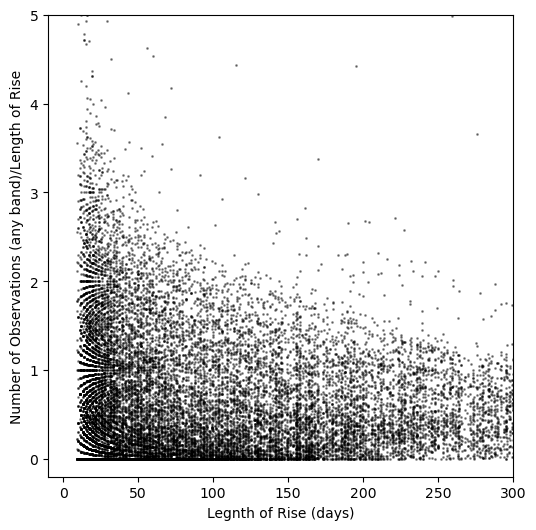

In [44]:
plt.figure(figsize=(6,6))
for i in range(nb_opsim):
    plt.scatter(nbrisedays, ratios_[:,i], c='k', s=1, alpha=.4);

plt.xlim(-10, 300)
plt.ylim(-.2,5)
plt.xlabel("Legnth of Rise (days)")
plt.ylabel("Number of Observations (any band)/Length of Rise")


In [36]:
## Mask for "short" rise

short_rise = np.array(nbrisedays) < 30
np.sum(obsrises[short_rise,:]==0)/len(obsrises[short_rise,:].reshape(-1))

0.47524613220815753

In [39]:
obsrises[short_rise,:]

array([[ 0,  4,  0,  0,  8],
       [12, 11, 13,  2,  6],
       [ 0,  0,  0,  0,  0],
       ...,
       [18,  0,  0,  0, 14],
       [ 4, 15,  0,  0,  0],
       [ 8, 26,  2, 30, 31]])

In [40]:
ratios_[short_rise,:]

array([[0.        , 0.26666667, 0.        , 0.        , 0.53333333],
       [1.09090909, 1.        , 1.18181818, 0.18181818, 0.54545455],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       ...,
       [1.5       , 0.        , 0.        , 0.        , 1.16666667],
       [0.28571429, 1.07142857, 0.        , 0.        , 0.        ],
       [0.38095238, 1.23809524, 0.0952381 , 1.42857143, 1.47619048]])

In [55]:
obsrises


array([[  4,  53,   0, 115,  66],
       [189,  31,   4,  72,  24],
       [310, 573, 225, 122, 236],
       ...,
       [150, 179, 110, 249,  91],
       [ 25,  47,  72,   0,   1],
       [  0, 155, 248, 189,  77]])

In [54]:
obsrises_flat[:12]

array([  4,  53,   0, 115,  66, 189,  31,   4,  72,  24, 310, 573])

In [75]:
nbriserepeat = np.repeat(nbrisedays, 5)
obsrises_flat = obsrises.reshape(-1)
ratios_flat = ratios_.reshape(-1)

In [65]:
import matplotlib as mpl

Text(0, 0.5, 'Number of Observations (any band)')

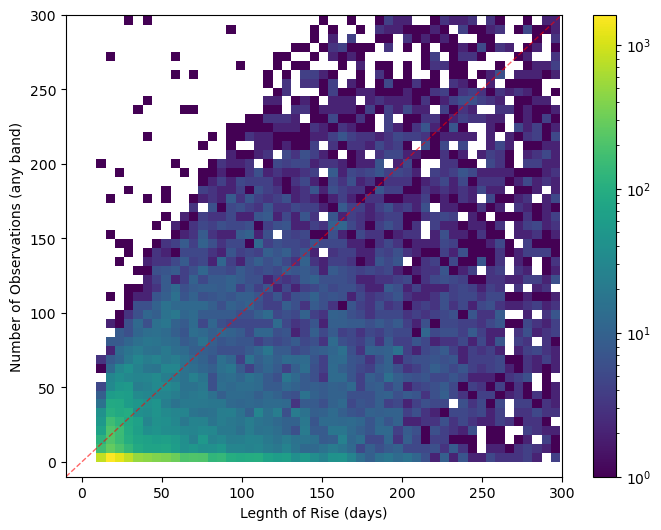

In [67]:
plt.figure(figsize=(8,6))
mask = (nbriserepeat < 300) & (obsrises_flat < 300) #& (obsrises_flat>0)
plt.hist2d(nbriserepeat[mask], obsrises_flat[mask], bins=50, norm=mpl.colors.LogNorm());
plt.colorbar()
plt.plot([-10,400],[-10,400], ls='--', c='r', alpha=.6, lw=1)
plt.xlim(-10, 300)
plt.ylim(-10,300)
plt.xlabel("Legnth of Rise (days)")
plt.ylabel("Number of Observations (any band)")


Text(0, 0.5, 'Number of Observations (any band)')

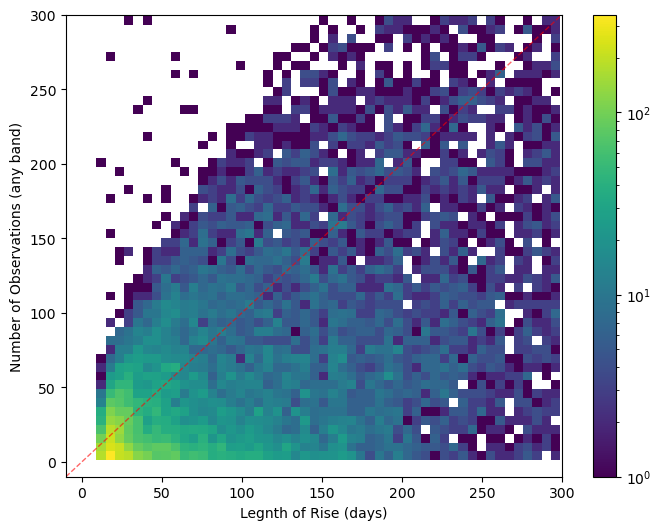

In [74]:
plt.figure(figsize=(8,6))
mask = (nbriserepeat < 300) & (obsrises_flat < 300) & (obsrises_flat>0)
plt.hist2d(nbriserepeat[mask], obsrises_flat[mask], bins=50, norm=mpl.colors.LogNorm());
plt.colorbar()
plt.plot([-10,400],[-10,400], ls='--', c='r', alpha=.6, lw=1)
plt.xlim(-10, 300)
plt.ylim(-10,300)
plt.xlabel("Legnth of Rise (days)")
plt.ylabel("Number of Observations (any band)")


Text(0, 0.5, 'Number of Observations (any band)')

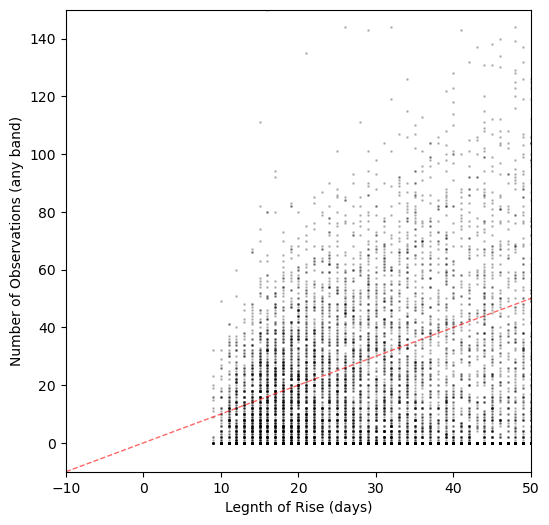

In [72]:
plt.figure(figsize=(6,6))
mask = (nbriserepeat < 300) & (obsrises_flat < 300)# & (obsrises_flat>0)
plt.scatter(nbriserepeat[mask], obsrises_flat[mask], c='k', s=1, alpha=.2);

plt.plot([-10,400],[-10,400], ls='--', c='r', alpha=.6, lw=1)
plt.xlim(-10, 50)
plt.ylim(-10,150)
plt.xlabel("Legnth of Rise (days)")
plt.ylabel("Number of Observations (any band)")


Text(0, 0.5, 'Number of Observations (any band)/Length of Rise')

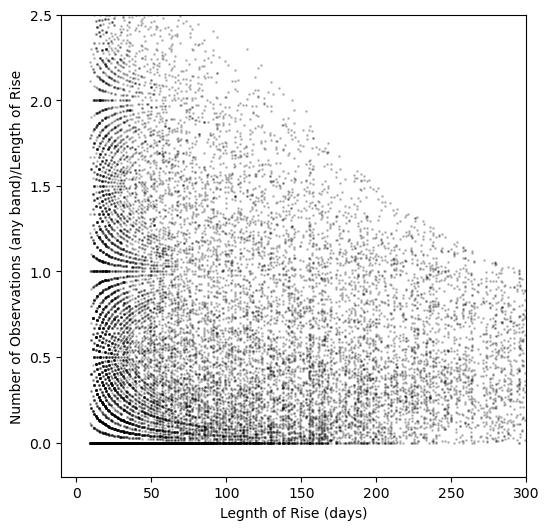

In [81]:
plt.figure(figsize=(6,6))
mask = (nbriserepeat < 300) & (obsrises_flat < 300)# & (obsrises_flat>0)
plt.scatter(nbriserepeat[mask], ratios_flat[mask], c='k', s=1, alpha=.2);

plt.xlim(-10, 300)
plt.ylim(-.2,2.5)
plt.xlabel("Legnth of Rise (days)")
plt.ylabel("Number of Observations (any band)/Length of Rise")


Text(0, 0.5, 'Number of Observations (any band)/Length of Rise')

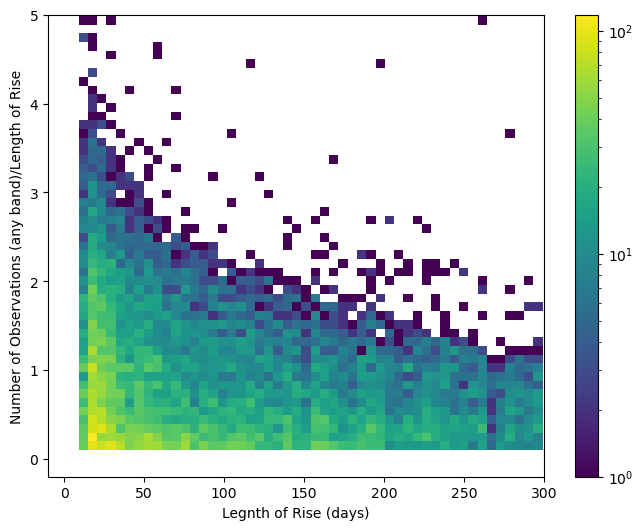

In [80]:
plt.figure(figsize=(8,6))
mask = (nbriserepeat < 300) &  (ratios_flat < 5) & (ratios_flat>0.1) #(obsrises_flat < 300) & (obsrises_flat>0)
plt.hist2d(nbriserepeat[mask], ratios_flat[mask], bins=50, norm=mpl.colors.LogNorm());
plt.colorbar()

plt.xlim(-10, 300)
plt.ylim(-.2,5)
plt.xlabel("Legnth of Rise (days)")
plt.ylabel("Number of Observations (any band)/Length of Rise")


Text(0, 0.5, 'Number of Observations (any band)')

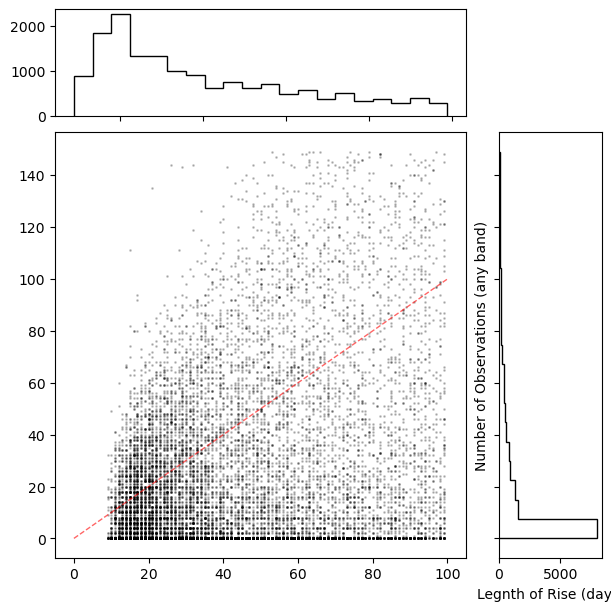

In [90]:

def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, c='k', s=1, alpha=.2)

    
    ax_histx.hist(x, bins=20, histtype='step', color='k')
    ax_histy.hist(y, bins=20, orientation='horizontal', histtype='step', color='k')
    
fig, axs = plt.subplot_mosaic([['histx', '.'],
                               ['scatter', 'histy']],
                              figsize=(6, 6),
                              width_ratios=(4, 1), height_ratios=(1, 4),
                              layout='constrained')

mask = (nbriserepeat < 100) #& (obsrises_flat < 150)# & (obsrises_flat>0)

            
scatter_hist(nbriserepeat[mask], obsrises_flat[mask], axs['scatter'], axs['histx'], axs['histy'])

axs['scatter'].plot([0,100],[0,100], ls='--', c='r', alpha=.6, lw=1)
# plt.xlim(-10, 50)
# plt.ylim(-10,150)
plt.xlabel("Legnth of Rise (days)")
plt.ylabel("Number of Observations (any band)")


## Let's just use the generated dataset, should prob average to the same stats

In [14]:
## Separate per bands

dir_lsst = "/d6/CAC/gcontardo/Data/MOSFITS_synth/apr13/lsst_synth_mosfitnoise_shavedT120/"

In [17]:
def get_rise_obs_from_LSST_lc(dflc_file, json_file, shave_time):

    
    ## So I pick a lightcurve, and put it somewhere on the sky
    band_list_cln = ['u','g','r','i','z','y']
    
    max_phase=1000 - shave_time
    
    #print(tmin, tmax)
    with open(json_file, 'r', encoding = 'utf-8') as f:
        data = json.loads(f.read())
        if 'name' not in data:
            data = data[list(data.keys())[0]]
    
    photo = data['photometry']
    model = data['models'][0]
    
    band_attr = ['band', 'instrument', 'telescope', 'system', 'bandset']
    band_list2 = list(set([tuple(x.get(y, '')
                                for y in band_attr) for x in photo
                                if 'band' in x and 'magnitude' in x]))
    
    ## 
    ## TODO Check how many real we got for all the TDEs generated, is it always...2?
    realiza = []
    for x in photo:
        realiza.append(x['realization'])
    realiza = np.unique(realiza)
    
    rea = realiza[0] ## 
    
    times = {b:[] for b in band_list_cln} # 
    truemagsMOS = {b:[] for b in band_list_cln}
    emagsMOS = {b:[] for b in band_list_cln}
    noisymagsMOS = {b:[] for b in band_list_cln}
    
    for x in photo:
        if x['realization']==rea:
            ### This removes some of the "useless" days before the start of the even, if we want that. 
            ### 
            if float(x['time'])>=shave_time:
                times[x['band']].append(float(x['time']))
                truemagsMOS[x['band']].append(float(x['magnitude']))
                emagsMOS[x['band']].append(float(x['e_magnitude']))
                noisymagsMOS[x['band']].append(float(x['magnitude']) +  np.random.normal(0, float(x['e_magnitude'])))
    
    # Have to cheat for the times...
    peak_day = {b:[] for b in band_list_cln} # 
    for b in band_list_cln:
        times[b] = np.arange(len(times[b]))
        peak_day[b] = times[b][np.argmin(truemagsMOS[b])]

    ##Figure out the peak day... Let's pick a band to estimate it
    

    rise_day = 149 - shave_time
    
    new_db = pd.read_csv(dflc_file)

    nb_obs_rise = []
    nb_rise_day = []
    for b in band_list_cln:
        nb_obs_rise.append(len(new_db[(new_db['filter']==b) & (new_db['MOSFITday']>=rise_day) & (new_db['MOSFITday']<=peak_day[b])]))

        nb_rise_day.append(peak_day[b]-rise_day)
        
    return nb_rise_day, nb_obs_rise



In [18]:

nbrisesday, nbobsrises = [], []

dir_lsst = "/d6/CAC/gcontardo/Data/MOSFITS_synth/apr13/lsst_synth_mosfitnoise_shavedT120/"
for i in range(len(df_tdes)):
    json_Tde = f"/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_{int(df_tdes["label"].iloc[i])}.json"
    
    try:
        
        dflc_file = dir_lsst+f"synth_tde_{int(df_tdes["label"].iloc[i])}.csv"
        nbrise_day, obsrise_ = get_rise_obs_from_LSST_lc(dflc_file, json_Tde, shave_time=120)
        nbrisesday.append(nbrise_day)
        nbobsrises.append(obsrise_)
        
    except FileNotFoundError:
        print(f"{i} is missing?")

17 is missing?
1355 is missing?
1356 is missing?
1407 is missing?
1493 is missing?
2708 is missing?
3209 is missing?
3272 is missing?
3311 is missing?
3414 is missing?
3465 is missing?
3589 is missing?
3714 is missing?
4082 is missing?
4374 is missing?
4586 is missing?
4620 is missing?
5055 is missing?
5211 is missing?
5245 is missing?
5360 is missing?
5608 is missing?
5702 is missing?
6831 is missing?
7102 is missing?
7199 is missing?
7219 is missing?
7282 is missing?
7737 is missing?
8041 is missing?
8244 is missing?
8847 is missing?
9241 is missing?
9354 is missing?
10378 is missing?
10834 is missing?
10883 is missing?
11175 is missing?
11700 is missing?
12882 is missing?
12933 is missing?
13067 is missing?
13187 is missing?
13217 is missing?
13466 is missing?
13879 is missing?
15431 is missing?
16014 is missing?
16269 is missing?
16534 is missing?
16853 is missing?
17663 is missing?
17844 is missing?
17977 is missing?
18273 is missing?
18940 is missing?
19096 is missing?
19359 is m

In [19]:
nbrisesday = np.array(nbrisesday)
nbobsrises = np.array(nbobsrises)
nbobsrises.shape

(23932, 6)

## Extra plots

"colors reflecting the fraction of the TDEs with a given rise time" you mean that for a given x-value (#rise-days) the bins in that "column" should sum to one and reflect the proportion of events with X rise-days that get N observations?


plot per band

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


(20,)
(20, 10)
(20, 10)


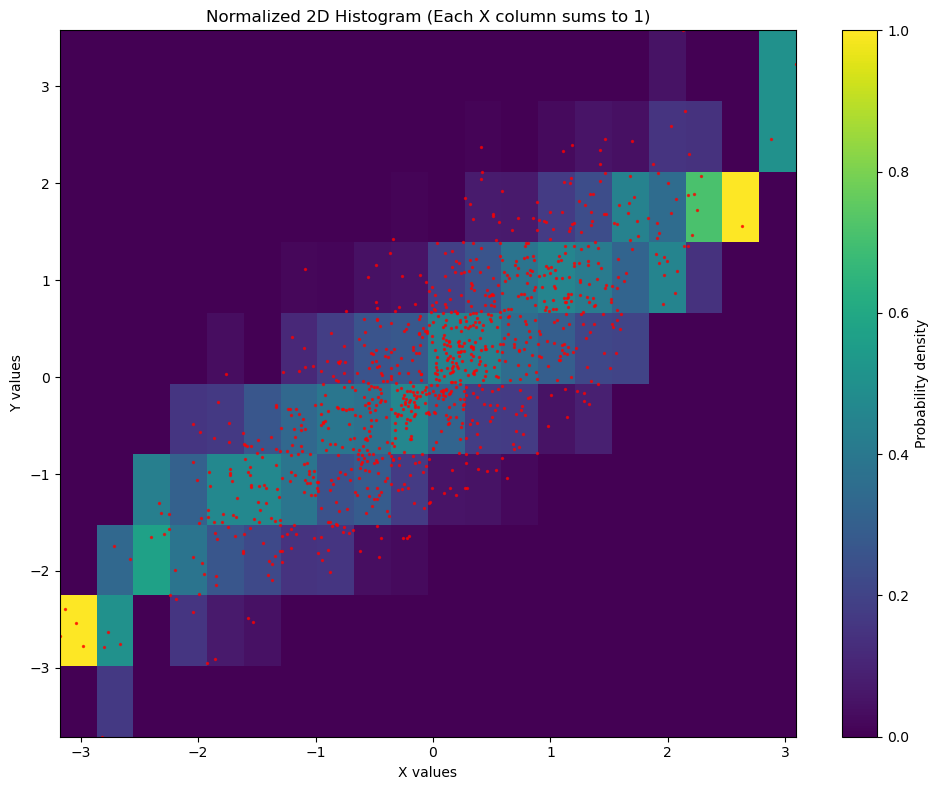

Sum of each normalized column: [0.16666667 1.76495726 2.14465267 2.899113   2.95740114 2.79103429
 2.7456278  3.06129716 0.91925001 0.55      ]


In [63]:

# 
# x = np.random.normal(0, 1, 1000)
# y = x + np.random.normal(0, 1, 1000)
# 
# x = np.random.uniform(0, 1, 1000)
# y = 0.0 + np.random.normal(0, 0.1, 1000) 

var_x = 1.0   
var_y = 1.0  
mean = [0, 0]
correlation = 0.8#0.8  
cov_xy = correlation * np.sqrt(var_x * var_y) 
cov_matrix = [[var_x, cov_xy], 
              [cov_xy, var_y]]
data = np.random.multivariate_normal(mean, cov_matrix, 1000)
x = data[:, 0]
y = data[:, 1]

nb_x_bin = 20
hist, x_edges, y_edges = np.histogram2d(x, y, bins=(nb_x_bin,10))
## I have 10 bins in x


# Calculate the sum for each x-bin (column)
x_bin_sums = np.sum(hist, axis=1)  # Sum over y values for each x bin
print(x_bin_sums.shape) ## This should give me 10 numbers (one for each x-bin)
epsilon = 1e-10
x_bin_sums[np.where(x_bin_sums == 0)[0]] =  epsilon 


# Normalize
print(hist.shape)
## Ugly but ?
normalized_hist = np.array([hist[i,:]/x_bin_sums[i] for i in range(nb_x_bin)])
print(normalized_hist.shape)


# Create plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the normalized 2D histogram
pcm = ax.pcolormesh(x_edges, y_edges, normalized_hist.T, 
                   cmap='viridis', shading='auto', vmin=0, vmax=1)

# Add a colorbar
cbar = fig.colorbar(pcm, ax=ax, label='Probability density')

plt.scatter(x,y,s=2, c='r', alpha=.7);
# Add labels and title
ax.set_xlabel('X values')
ax.set_ylabel('Y values')
ax.set_title('Normalized 2D Histogram (Each X column sums to 1)')

plt.tight_layout()
plt.show()

# Optional: Print the sum of each column to verify they equal 1
print("Sum of each normalized column:", normalized_hist.sum(axis=0))

In [27]:
import matplotlib.cm as cm
import matplotlib

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
(20,)
(20, 20)
(20, 20)


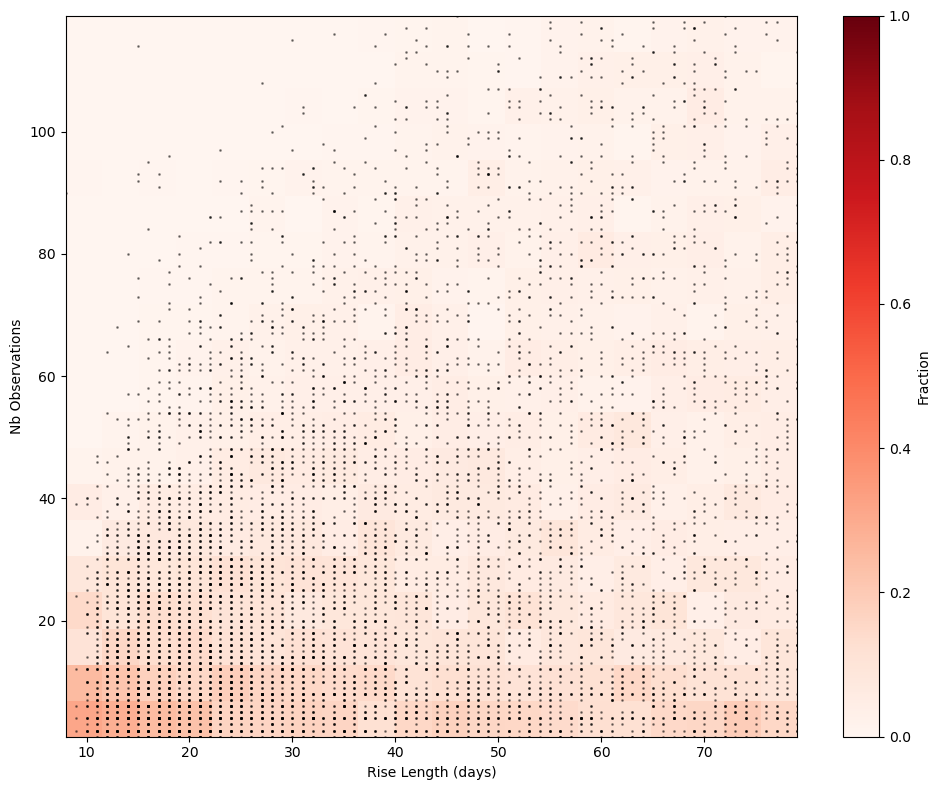

In [95]:
band_list_cln = ['u','g','r','i','z','y']

b=0
mask = (nbrisesday[:,b] < 80) & (nbobsrises[:,b] < 120)  & (nbobsrises[:,b] > 0)


x = nbrisesday[:,b][mask]
y = nbobsrises[:,b][mask]


nb_x_bin = 20
nb_y_bin = 20
hist, x_edges, y_edges = np.histogram2d(x, y, bins=(nb_x_bin,nb_y_bin))



# Calculate the sum for each x-bin (column)
x_bin_sums = np.sum(hist, axis=1)  # Sum over y values for each x bin
print(x_bin_sums.shape) ## 
epsilon = 1e-10
x_bin_sums[np.where(x_bin_sums == 0)[0]] =  epsilon 


# Normalize
print(hist.shape)
## Ugly but ?
normalized_hist = np.array([hist[i,:]/x_bin_sums[i] for i in range(nb_x_bin)])
print(normalized_hist.shape)


# Create plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the normalized 2D histogram
pcm = ax.pcolormesh(x_edges, y_edges, normalized_hist.T, 
                   cmap=cm.Reds, vmin=0, vmax=1)

# Add a colorbar
cbar = fig.colorbar(pcm, ax=ax, label='Fraction')

plt.scatter(x,y,s=1, c='k', alpha=.4, rasterized=True);
# Add labels and title
ax.set_xlabel('Rise Length (days)')
ax.set_ylabel('Nb Observations')

plt.tight_layout()
plt.show()

In [22]:
b=0
mask = (nbrisesday[:,b] < 80) & (nbobsrises[:,b] < 120)  & (nbobsrises[:,b] > 0)


x = nbobsrises[:,b][mask]

b=4
mask = (nbrisesday[:,b] < 80) & (nbobsrises[:,b] < 120)  & (nbobsrises[:,b] > 0)


x2 = nbobsrises[:,b][mask]
print(x)
print(x2)

[3 8 2 ... 3 2 1]
[ 1 12 24 ...  8 11  1]


0 0
0 1
0 2
1 3
1 4
1 5


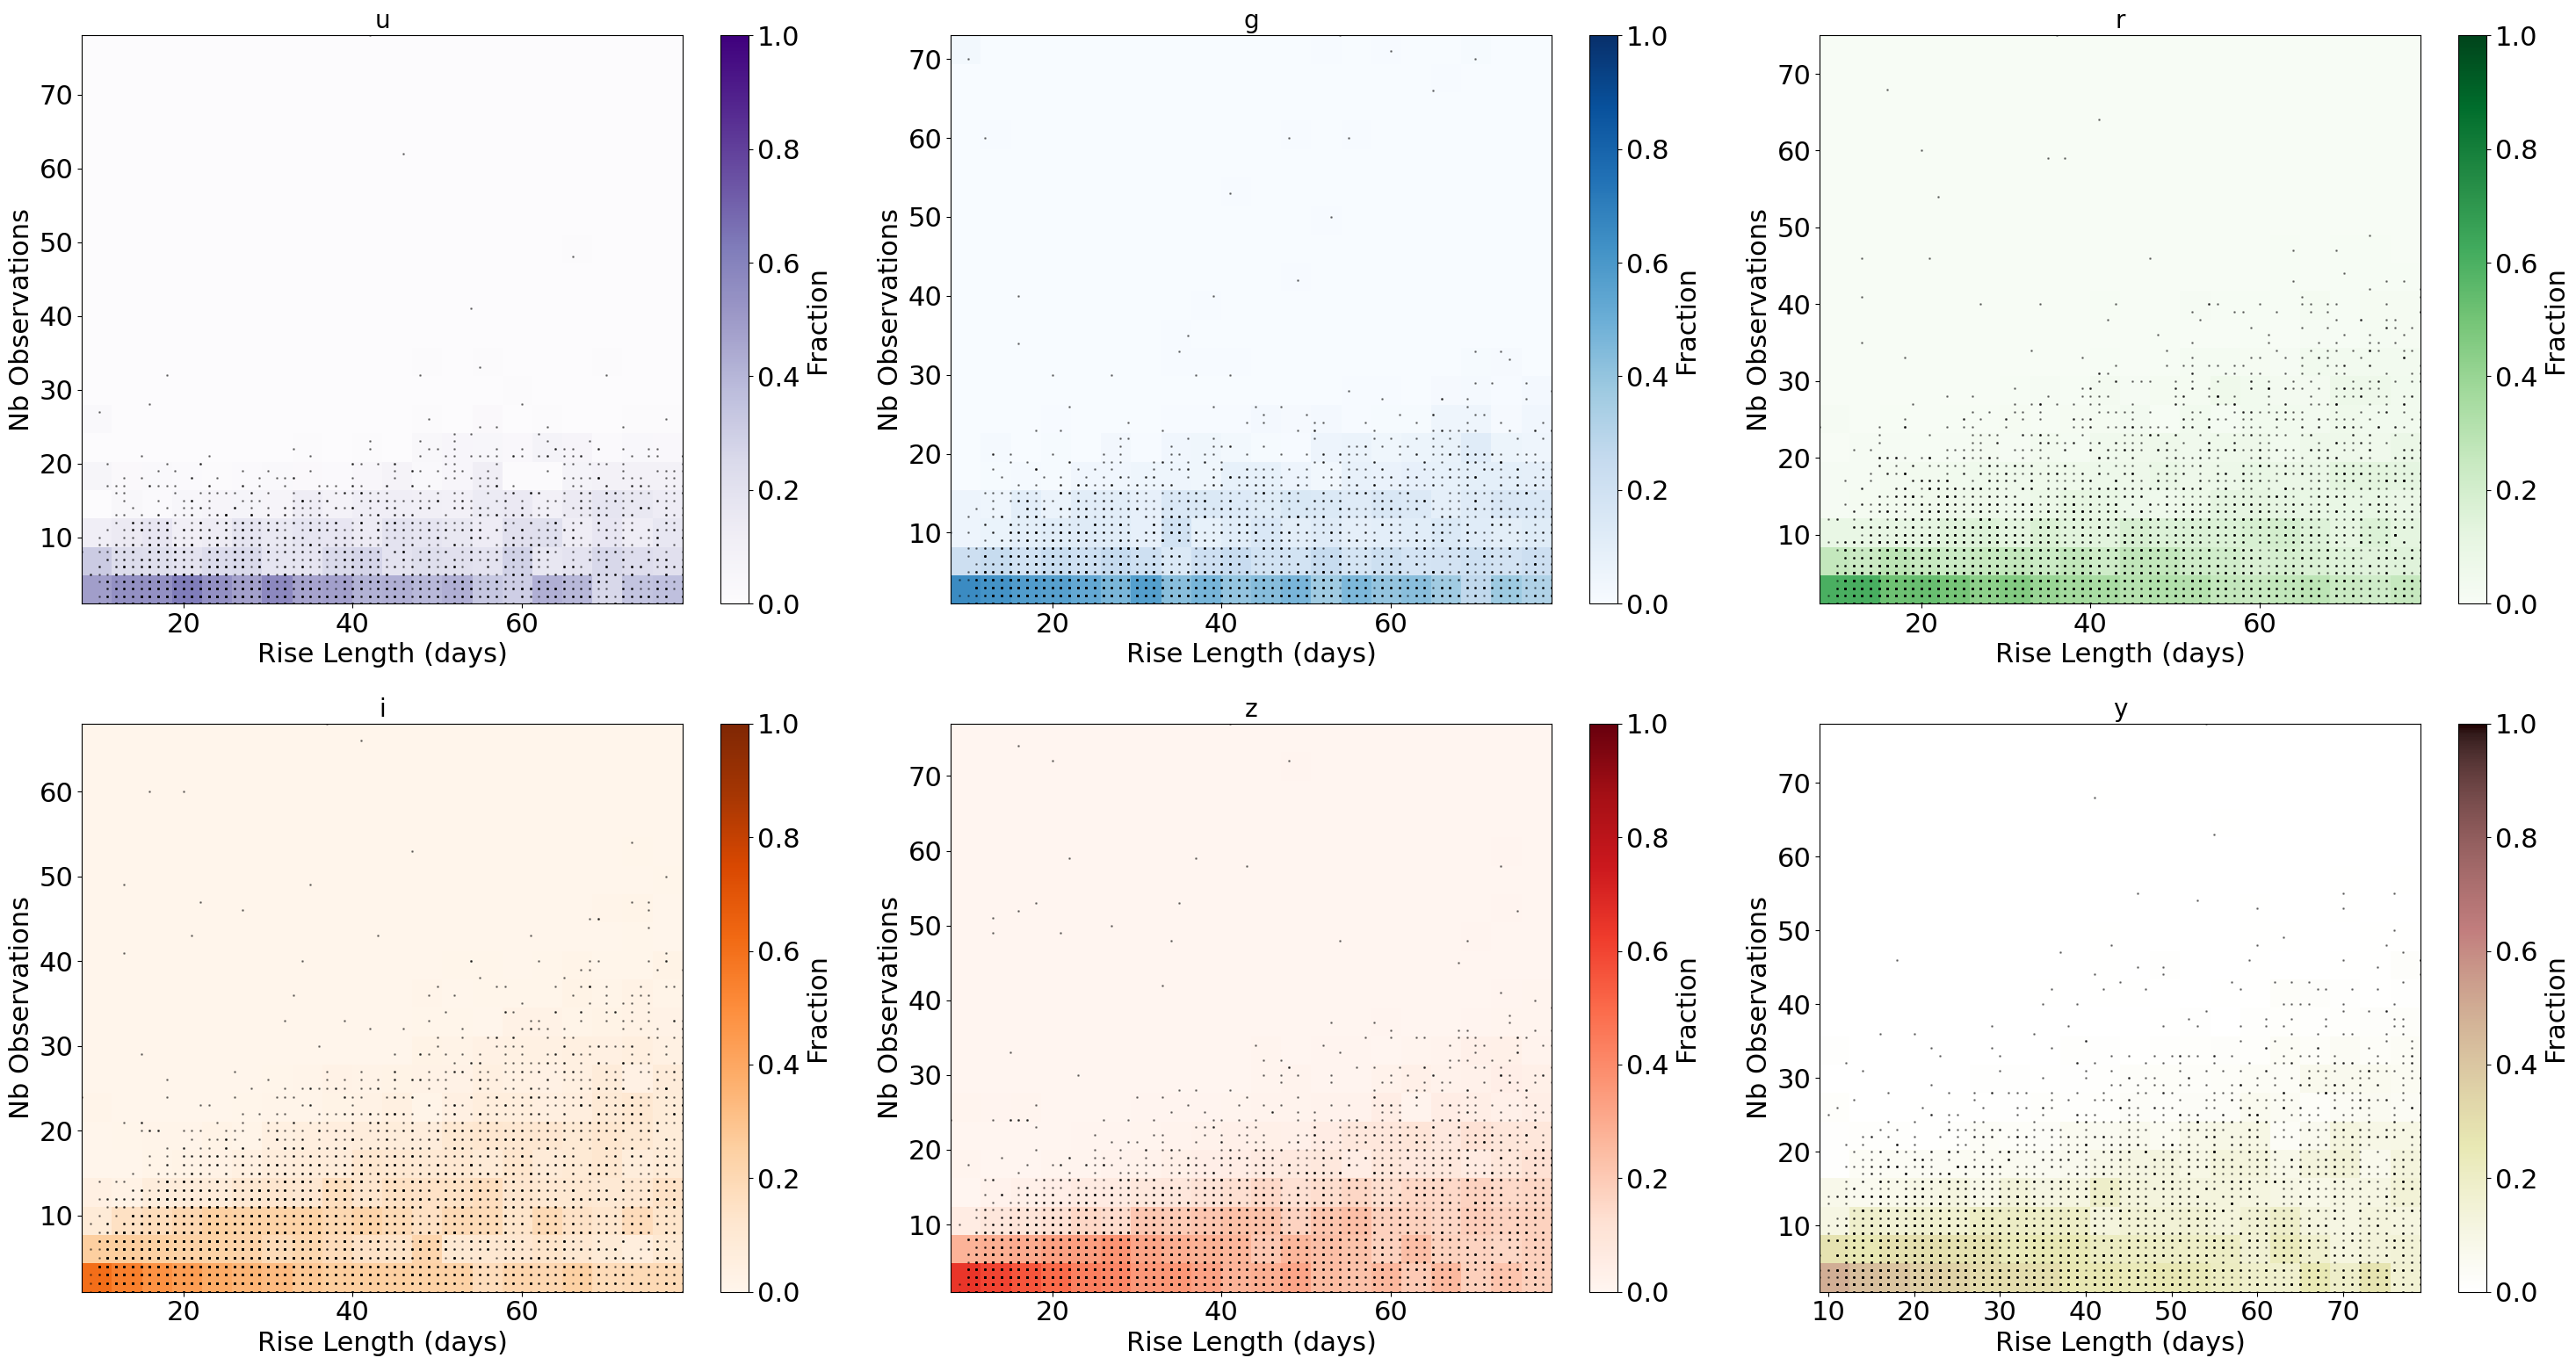

In [29]:
band_list_cln = ['u','g','r','i','z','y']
#Greys, Purples, Blues, Greens, Oranges, Reds, YlOrBr, RdPu, BuPu,YlGn
#u = purple, g=blue, r=green, i=orange, z= red, y= brown
cmaps = [ cm.Purples, cm.Blues, cm.Greens, cm.Oranges, cm.Reds, cm.pink_r]

matplotlib.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(2,3, figsize=(10*3, 8*2))

for b in range(len(band_list_cln)):
    
    mask = (nbrisesday[:,b] < 80) & (nbobsrises[:,b] < 80)  & (nbobsrises[:,b] > 0)
    
    
    x = nbrisesday[:,b][mask]
    y = nbobsrises[:,b][mask]
    
    
    nb_x_bin = 20
    nb_y_bin = 20
    hist, x_edges, y_edges = np.histogram2d(x, y, bins=(nb_x_bin,nb_y_bin))
    
    
    
    # Calculate the sum for each x-bin (column)
    x_bin_sums = np.sum(hist, axis=1)  # Sum over y values for each x bin

    epsilon = 1e-10
    x_bin_sums[np.where(x_bin_sums == 0)[0]] =  epsilon 
    
    
    # Normalize
    ## Ugly but ?
    normalized_hist = np.array([hist[i,:]/x_bin_sums[i] for i in range(nb_x_bin)])
    print(int(b/3), b%6)
    ax = axs[int(b/3), b%3] 
    
    # Plot the normalized 2D histogram
    pcm = ax.pcolormesh(x_edges, y_edges, normalized_hist.T, 
                       cmap=cmaps[b], vmin=0, vmax=1)
    
    # Add a colorbar
    cbar = fig.colorbar(pcm, ax=ax, label='Fraction')
    
    ax.scatter(x,y,s=1, c='k', alpha=.4, rasterized=True);
    # Add labels and title
    ax.set_xlabel('Rise Length (days)')
    ax.set_ylabel('Nb Observations')
    ax.set_title(band_list_cln[b], fontsize=20)

plt.tight_layout()
plt.show()

0 0
0 1
0 2
1 3
1 4
1 5


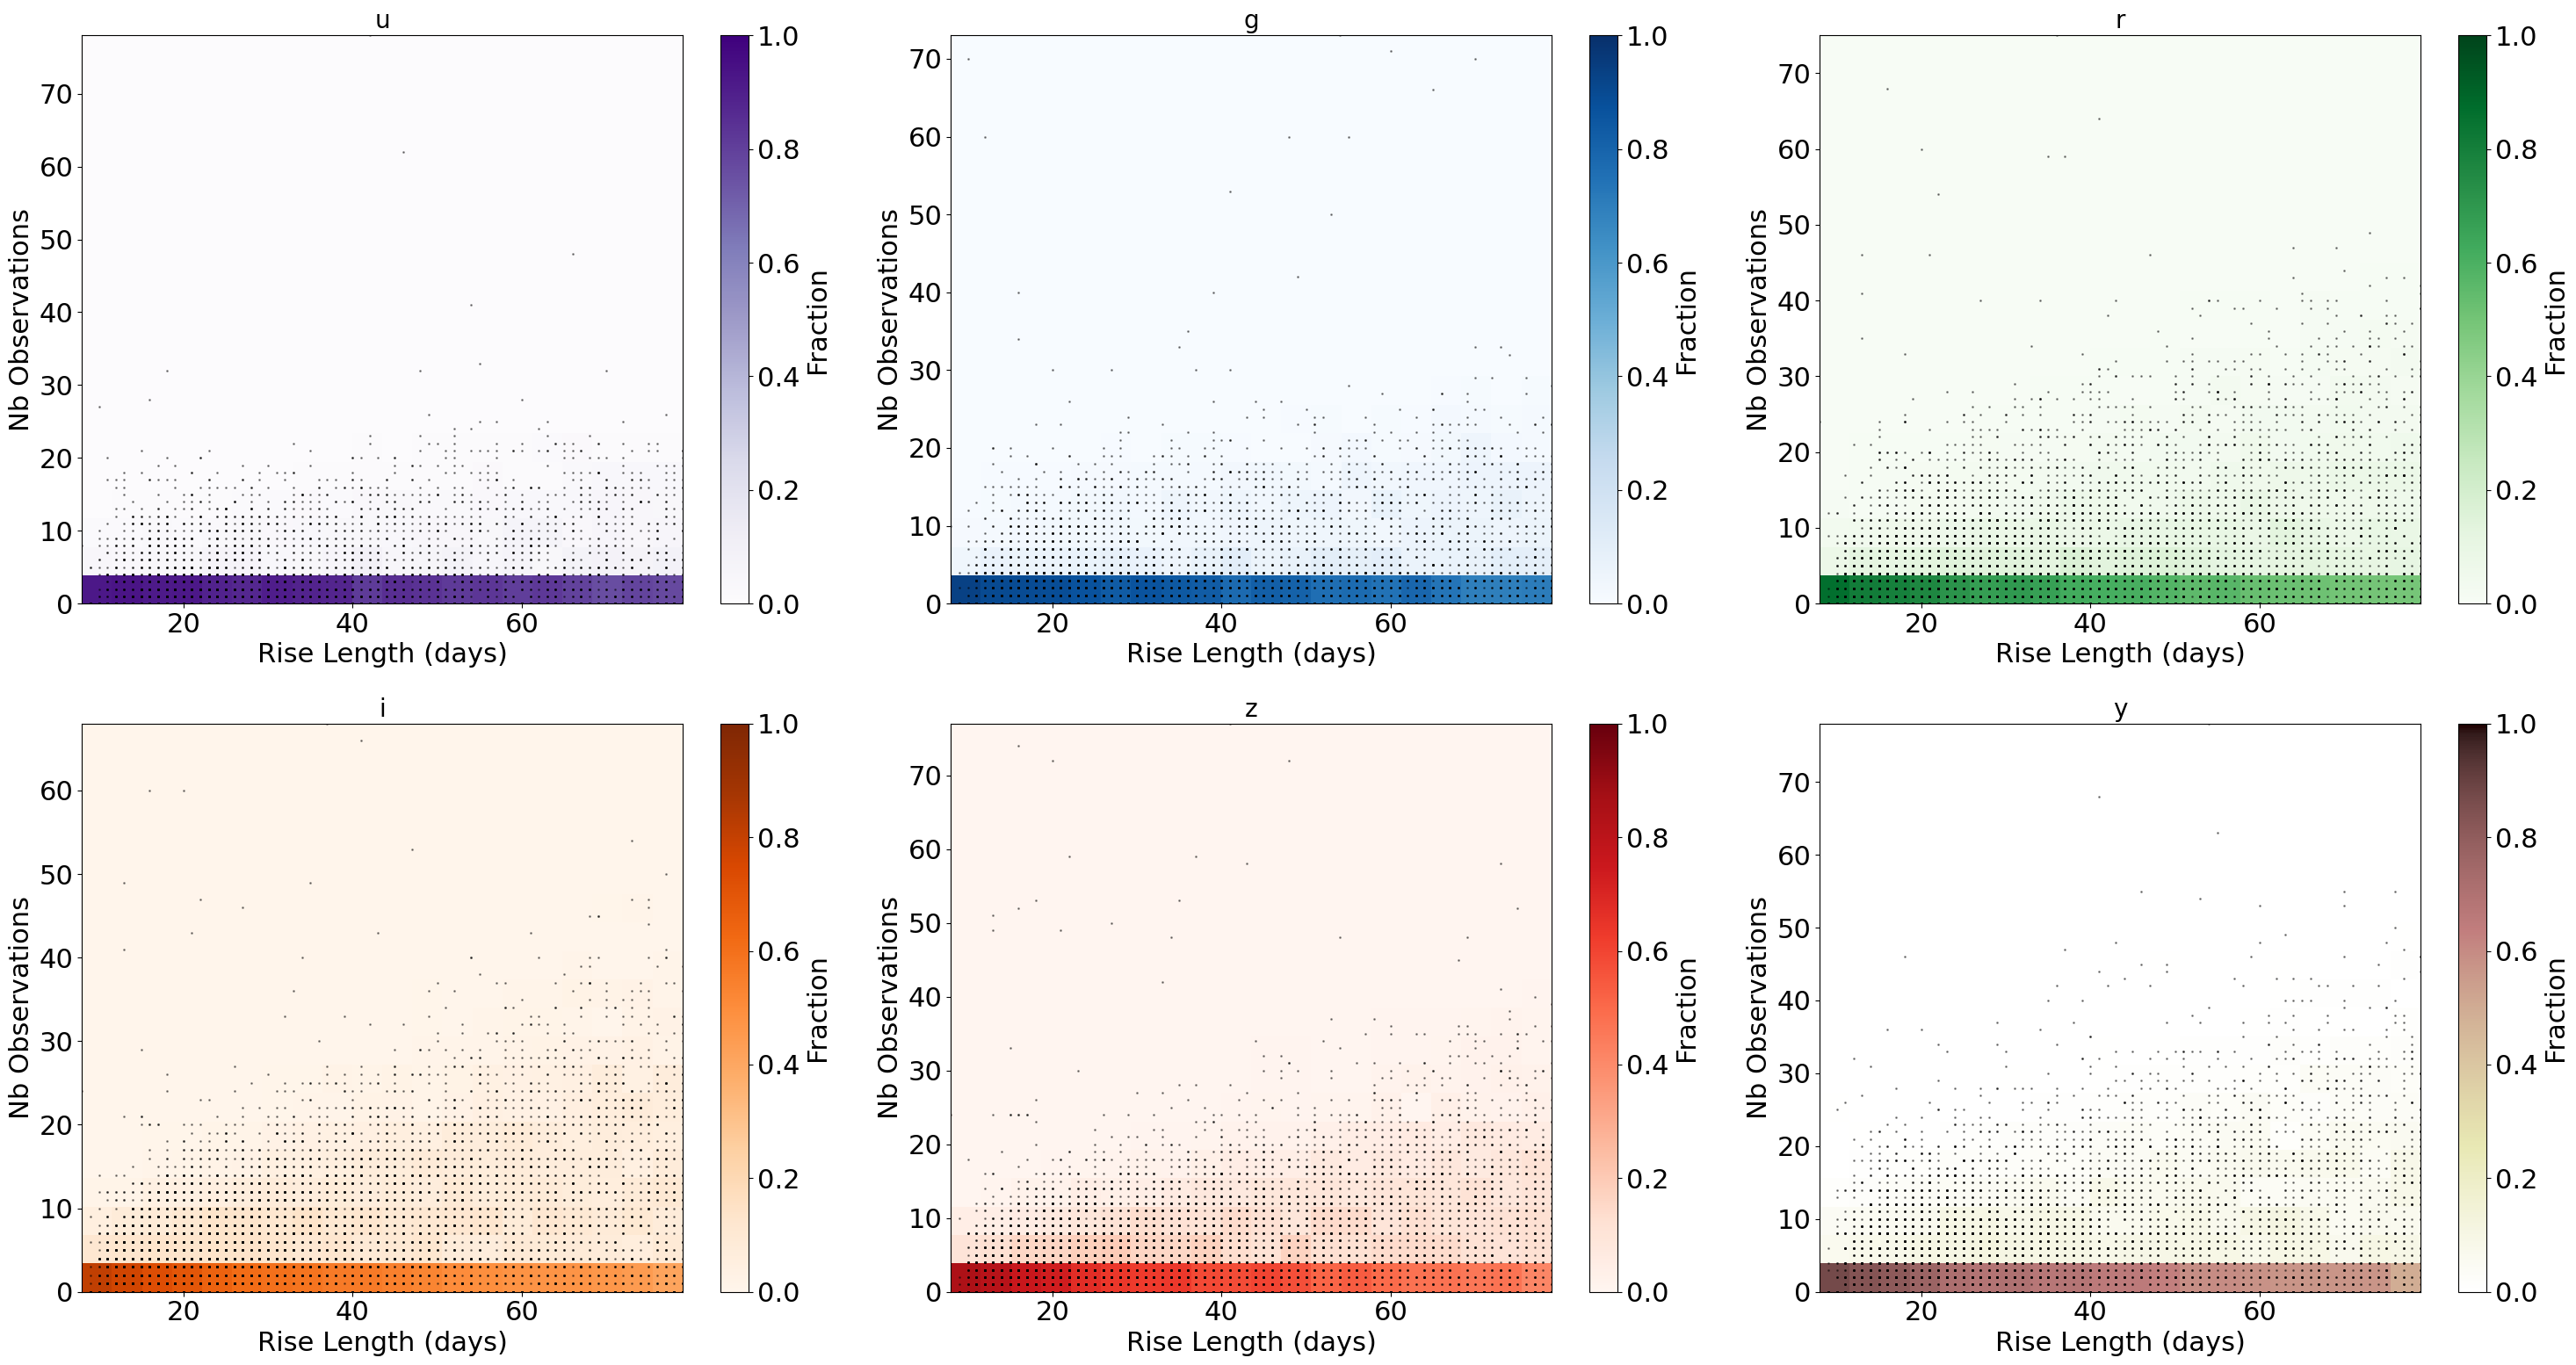

In [30]:
band_list_cln = ['u','g','r','i','z','y']
#Greys, Purples, Blues, Greens, Oranges, Reds, YlOrBr, RdPu, BuPu,YlGn
#u = purple, g=blue, r=green, i=orange, z= red, y= brown
cmaps = [ cm.Purples, cm.Blues, cm.Greens, cm.Oranges, cm.Reds, cm.pink_r]

matplotlib.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(2,3, figsize=(10*3, 8*2))

for b in range(len(band_list_cln)):
    
    mask = (nbrisesday[:,b] < 80) & (nbobsrises[:,b] < 80)  # & (nbobsrises[:,b] > 0)
    
    
    x = nbrisesday[:,b][mask]
    y = nbobsrises[:,b][mask]
    
    
    nb_x_bin = 20
    nb_y_bin = 20
    hist, x_edges, y_edges = np.histogram2d(x, y, bins=(nb_x_bin,nb_y_bin))
    
    
    
    # Calculate the sum for each x-bin (column)
    x_bin_sums = np.sum(hist, axis=1)  # Sum over y values for each x bin

    epsilon = 1e-10
    x_bin_sums[np.where(x_bin_sums == 0)[0]] =  epsilon 
    
    
    # Normalize
    ## Ugly but ?
    normalized_hist = np.array([hist[i,:]/x_bin_sums[i] for i in range(nb_x_bin)])
    print(int(b/3), b%6)
    ax = axs[int(b/3), b%3] 
    
    # Plot the normalized 2D histogram
    pcm = ax.pcolormesh(x_edges, y_edges, normalized_hist.T, 
                       cmap=cmaps[b], vmin=0, vmax=1)
    
    # Add a colorbar
    cbar = fig.colorbar(pcm, ax=ax, label='Fraction')
    
    ax.scatter(x,y,s=1, c='k', alpha=.4, rasterized=True);
    # Add labels and title
    ax.set_xlabel('Rise Length (days)')
    ax.set_ylabel('Nb Observations')
    ax.set_title(band_list_cln[b], fontsize=20)

plt.tight_layout()
plt.show()

0 0
0 1
0 2
1 3
1 4
1 5


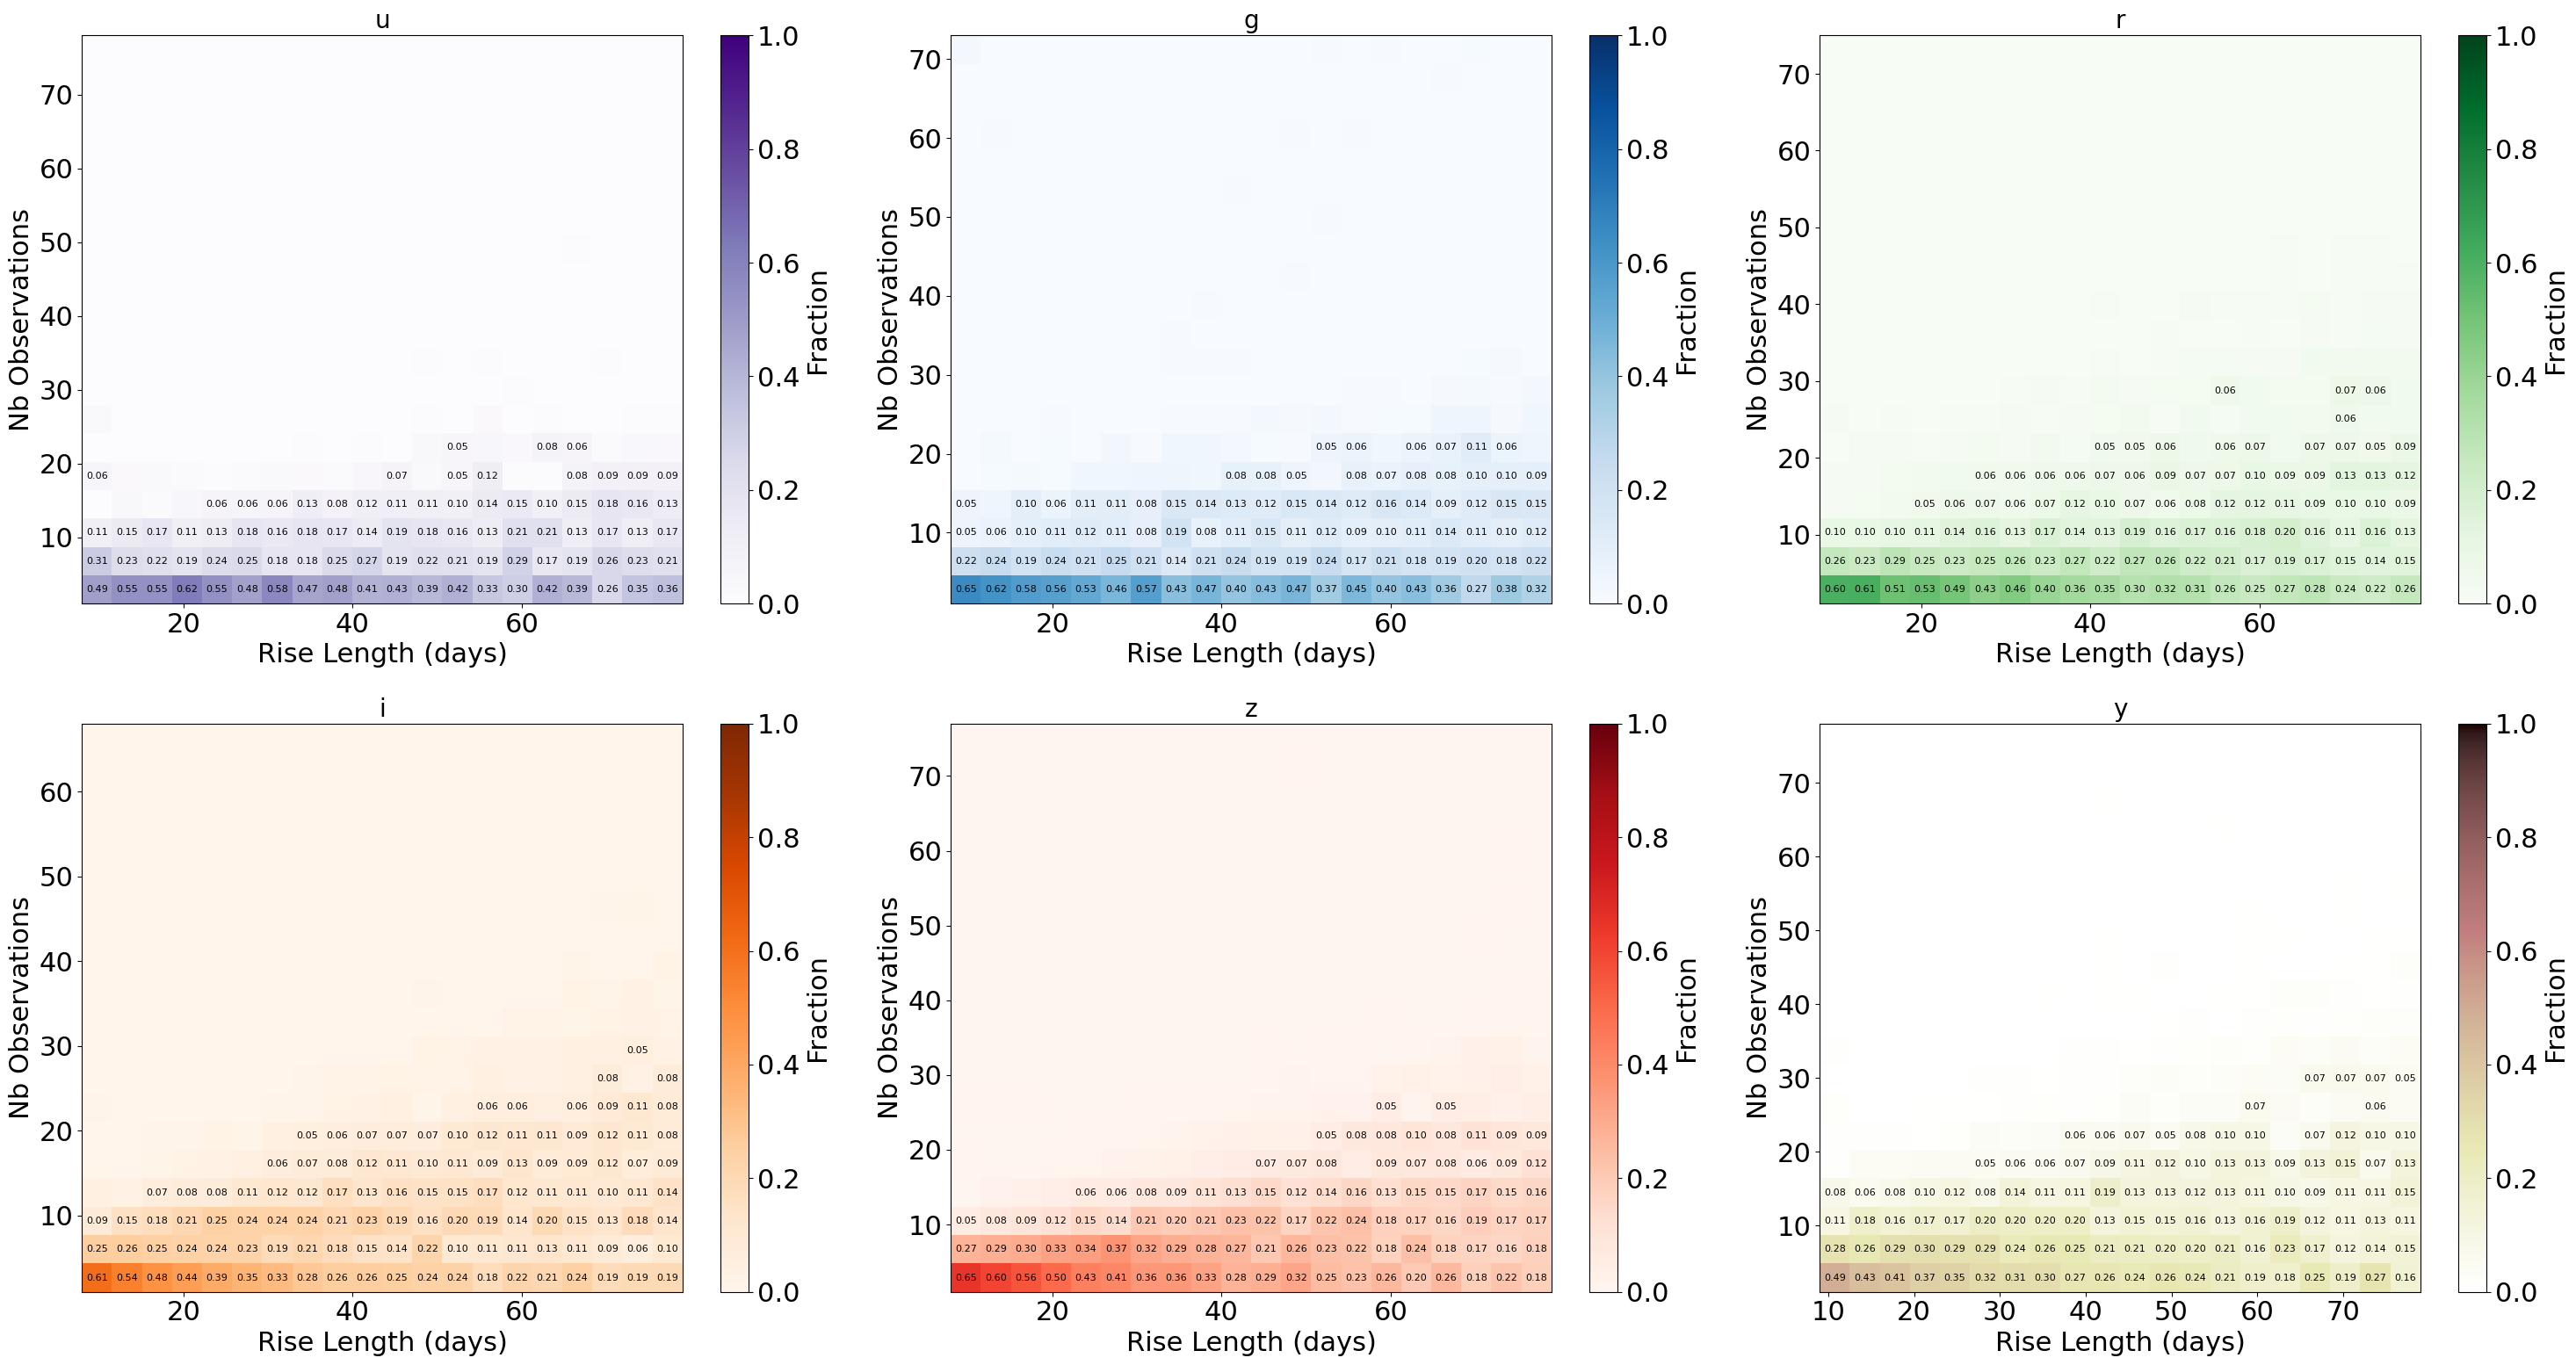

In [38]:
band_list_cln = ['u','g','r','i','z','y']
#Greys, Purples, Blues, Greens, Oranges, Reds, YlOrBr, RdPu, BuPu,YlGn
#u = purple, g=blue, r=green, i=orange, z= red, y= brown
cmaps = [ cm.Purples, cm.Blues, cm.Greens, cm.Oranges, cm.Reds, cm.pink_r]

matplotlib.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(2,3, figsize=(10*3, 8*2))

for b in range(len(band_list_cln)):
    
    mask = (nbrisesday[:,b] < 80) & (nbobsrises[:,b] < 80)  & (nbobsrises[:,b] > 0)
    
    
    x = nbrisesday[:,b][mask]
    y = nbobsrises[:,b][mask]
    
    
    nb_x_bin = 20
    nb_y_bin = 20
    hist, x_edges, y_edges = np.histogram2d(x, y, bins=(nb_x_bin,nb_y_bin))
    
    
    
    # Calculate the sum for each x-bin (column)
    x_bin_sums = np.sum(hist, axis=1)  # Sum over y values for each x bin

    epsilon = 1e-10
    x_bin_sums[np.where(x_bin_sums == 0)[0]] =  epsilon 
    
    
    # Normalize
    ## Ugly but ?
    normalized_hist = np.array([hist[i,:]/x_bin_sums[i] for i in range(nb_x_bin)])
    print(int(b/3), b%6)
    ax = axs[int(b/3), b%3] 
    
    # Plot the normalized 2D histogram
    pcm = ax.pcolormesh(x_edges, y_edges, normalized_hist.T, 
                       cmap=cmaps[b], vmin=0, vmax=1)
    
    # Add a colorbar
    cbar = fig.colorbar(pcm, ax=ax, label='Fraction')
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    
    # Add text for counts in each cell
    for i in range(len(x_centers)):
        for j in range(len(y_centers)):
            count = normalized_hist[i,j] #int(hist[i, j])
            if count > 0.05:  # Only add text for non-empty bins
                # Choose text color based on background color (dark for light backgrounds, light for dark backgrounds)
                color = 'black'# 'white' if normalized_hist[i, j] > 0.5 else 'black'
                ax.text(x_centers[i], y_centers[j], "{:.2f}".format(normalized_hist[i,j]), 
                        ha='center', va='center', color=color, fontsize=8)
                
    #ax.scatter(x,y,s=1, c='k', alpha=.4, rasterized=True);
    # Add labels and title
    ax.set_xlabel('Rise Length (days)')
    ax.set_ylabel('Nb Observations')
    ax.set_title(band_list_cln[b], fontsize=20)

plt.tight_layout()
plt.show()

In [49]:
nbrisesday_copy = np.copy(nbrisesday)
nbobsrises_copy = np.copy(nbobsrises)


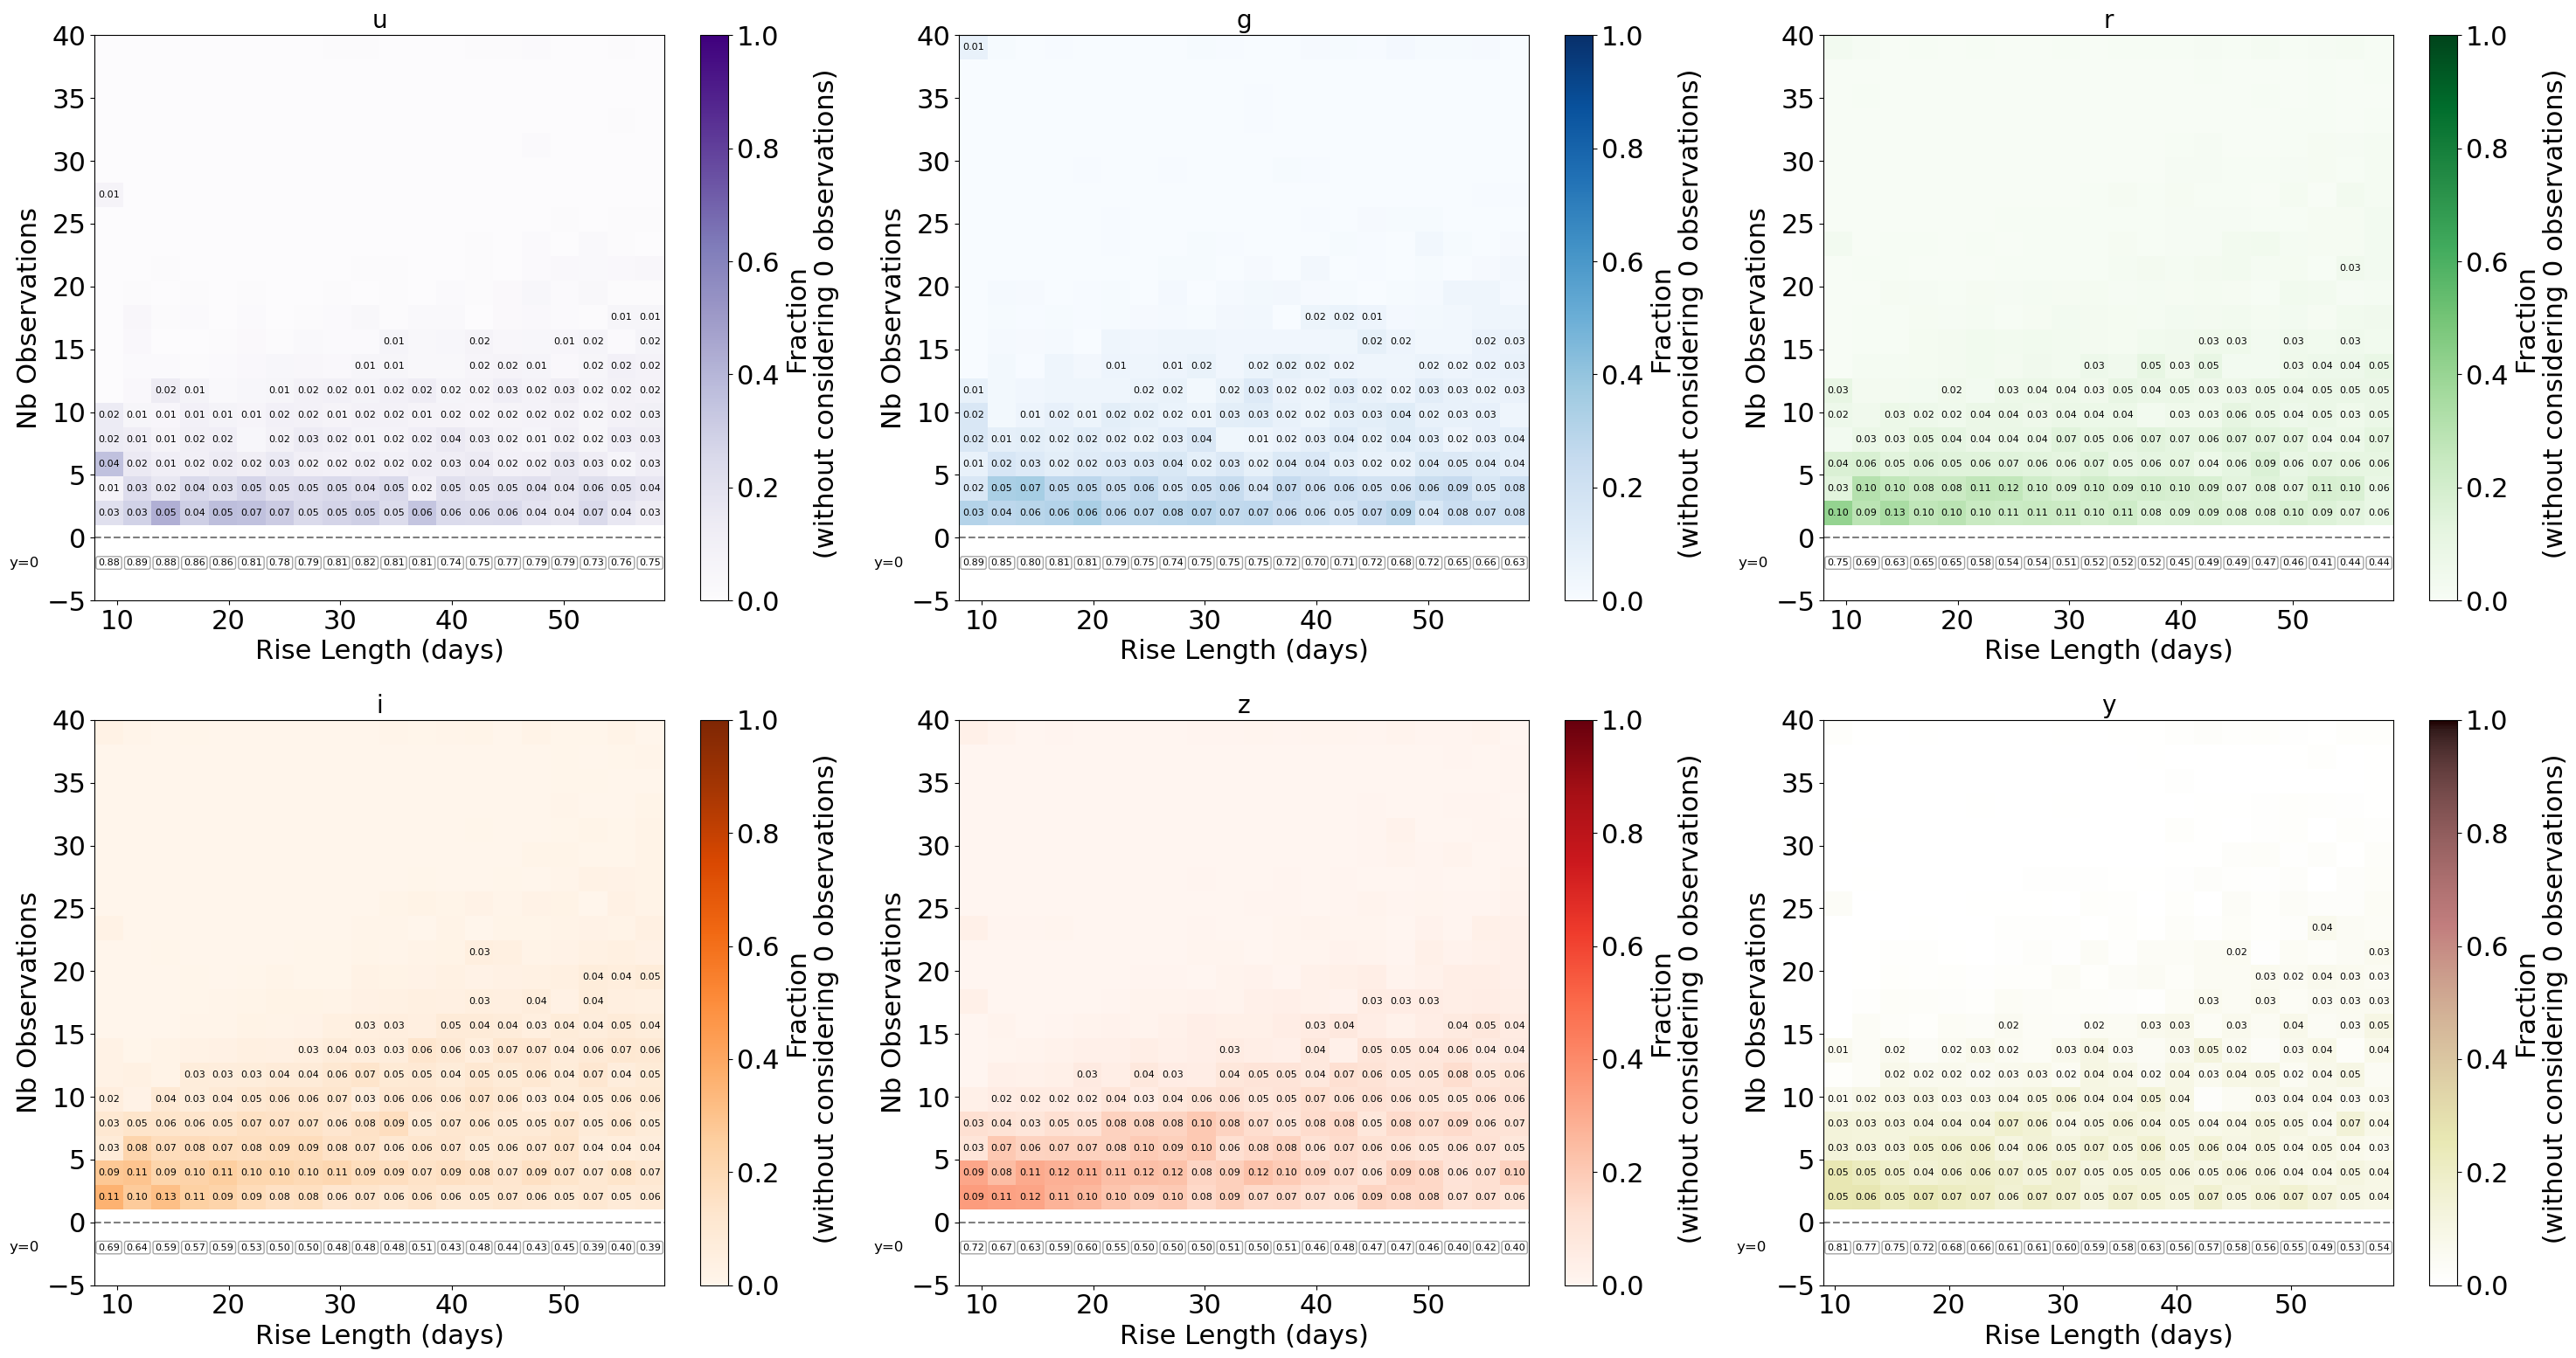

In [50]:
band_list_cln = ['u','g','r','i','z','y']
#Greys, Purples, Blues, Greens, Oranges, Reds, YlOrBr, RdPu, BuPu,YlGn
#u = purple, g=blue, r=green, i=orange, z= red, y= brown
cmaps = [cm.Purples, cm.Blues, cm.Greens, cm.Oranges, cm.Reds, cm.pink_r]
matplotlib.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(2, 3, figsize=(10*3, 8*2))


## Should I cap nbobsrises at max values to not lose ?
maxobs = 40
maxrise = 60
nb_x_bin = 20
nb_y_bin = 20

nbobsrises[np.where(nbobsrises>=maxobs)] = maxobs

for b in range(len(band_list_cln)):
    
    # Modified mask to include y==0 cases for counting but separate them
    mask_nonzero = (nbrisesday[:,b] < maxrise) & (nbobsrises[:,b] <= maxobs) & (nbobsrises[:,b] > 0)
    mask_zero = (nbrisesday[:,b] < maxrise) & (nbobsrises[:,b] == 0)
    
    # Data for plotting and coloring (y > 0)
    x_nonzero = nbrisesday[:,b][mask_nonzero]
    y_nonzero = nbobsrises[:,b][mask_nonzero]
    
    # Data for zero cases (y == 0)
    x_zero = nbrisesday[:,b][mask_zero]
    y_zero = nbobsrises[:,b][mask_zero]
    

    
    # Create the regular 2D histogram for colored visualization (y > 0)
    hist_nonzero, x_edges, y_edges = np.histogram2d(x_nonzero, y_nonzero, bins=(nb_x_bin, nb_y_bin))
    
    # Create histogram for y==0 cases
    hist_zero, x_edges_zero = np.histogram(x_zero, bins=x_edges)

    
    # Calculate the sum for each x-bin (column) including zero bins for normalization
    x_bin_sums = np.sum(hist_nonzero, axis=1)  # Sum over y values for each x bin
    
    
    epsilon = 1e-10
    x_bin_sums[np.where(x_bin_sums == 0)[0]] = epsilon 
    
    # Normalize
    normalized_hist = np.array([hist_nonzero[i,:]/x_bin_sums[i] for i in range(nb_x_bin)])
    
    ax = axs[int(b/3), b%3]
    
    # Plot the normalized 2D histogram (only for non-zero y values)
    pcm = ax.pcolormesh(x_edges, y_edges, normalized_hist.T, 
                        cmap=cmaps[b], vmin=0, vmax=1)
    
    # Add a colorbar
    cbar = fig.colorbar(pcm, ax=ax, label='Fraction\n (without considering 0 observations)')
    
    # Add the count numbers to each cell (for y > 0)
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2

    ## For the NUMBER PRINT we want to include the zeros 
    # Calculate the sum for each x-bin (column) including zero bins for normalization
    x_bin_sums = np.sum(hist_nonzero, axis=1)  # Sum over y values for each x bin
    for i in range(len(hist_zero)):
        x_bin_sums[i] += hist_zero[i]
    
    epsilon = 1e-10
    x_bin_sums[np.where(x_bin_sums == 0)[0]] = epsilon 
    
    # Normalize
    normalized_hist_w0 = np.array([hist_nonzero[i,:]/x_bin_sums[i] for i in range(nb_x_bin)])
    
    normalized_hist_zero = np.array([hist_zero[i]/x_bin_sums[i] for i in range(nb_x_bin)])
    
    # Add text for counts in each cell (y > 0)
    for i in range(len(x_centers)):
        for j in range(len(y_centers)):
            # count = int(hist_nonzero[i, j])
            # if count > 0:  # Only add text for non-empty bins
            #     color = 'white' if normalized_hist[i, j] > 0.5 else 'black'
            #     ax.text(x_centers[i], y_centers[j], str(count), 
            #             ha='center', va='center', color=color, fontsize=8)
            count = normalized_hist[i,j] #int(hist[i, j])
            if count > 0.05:  # Only add text for non-empty bins
                # Choose text color based on background color (dark for light backgrounds, light for dark backgrounds)
                color = 'black'# 'white' if normalized_hist[i, j] > 0.5 else 'black'
                ax.text(x_centers[i], y_centers[j], "{:.2f}".format(normalized_hist_w0[i,j]), 
                        ha='center', va='center', color=color, fontsize=8)
    
    # Add an extra row for y==0 cases (not colored but showing counts)
    y_zero_pos = -2  # Position below the y-axis start for visibility
    
    # Add a dashed line to separate the y==0 row
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)

    # Display counts for y==0 bins
    for i in range(len(x_centers)):
        count = normalized_hist_zero[i] #int(hist_zero[i])
        if count > 0:
            ax.text(x_centers[i], y_zero_pos, "{:.2f}".format(normalized_hist_zero[i]), 
                    ha='center', va='center', color='black', fontsize=8, 
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round,pad=0.2'))
    
    # Add a label for the y==0 row
    ax.text(x_edges[0] - 5, y_zero_pos, "y=0", ha='right', va='center', fontsize=12)
    
    
    # Add labels and title
    ax.set_xlabel('Rise Length (days)')
    ax.set_ylabel('Nb Observations')
    ax.set_title(band_list_cln[b], fontsize=20)
    
    # Adjust y-axis to make room for the y==0 row
    ax.set_ylim(y_zero_pos-3, ax.get_ylim()[1])

plt.tight_layout()
plt.savefig("fraction_observed_riselengths.pdf", dpi=50)
plt.show()

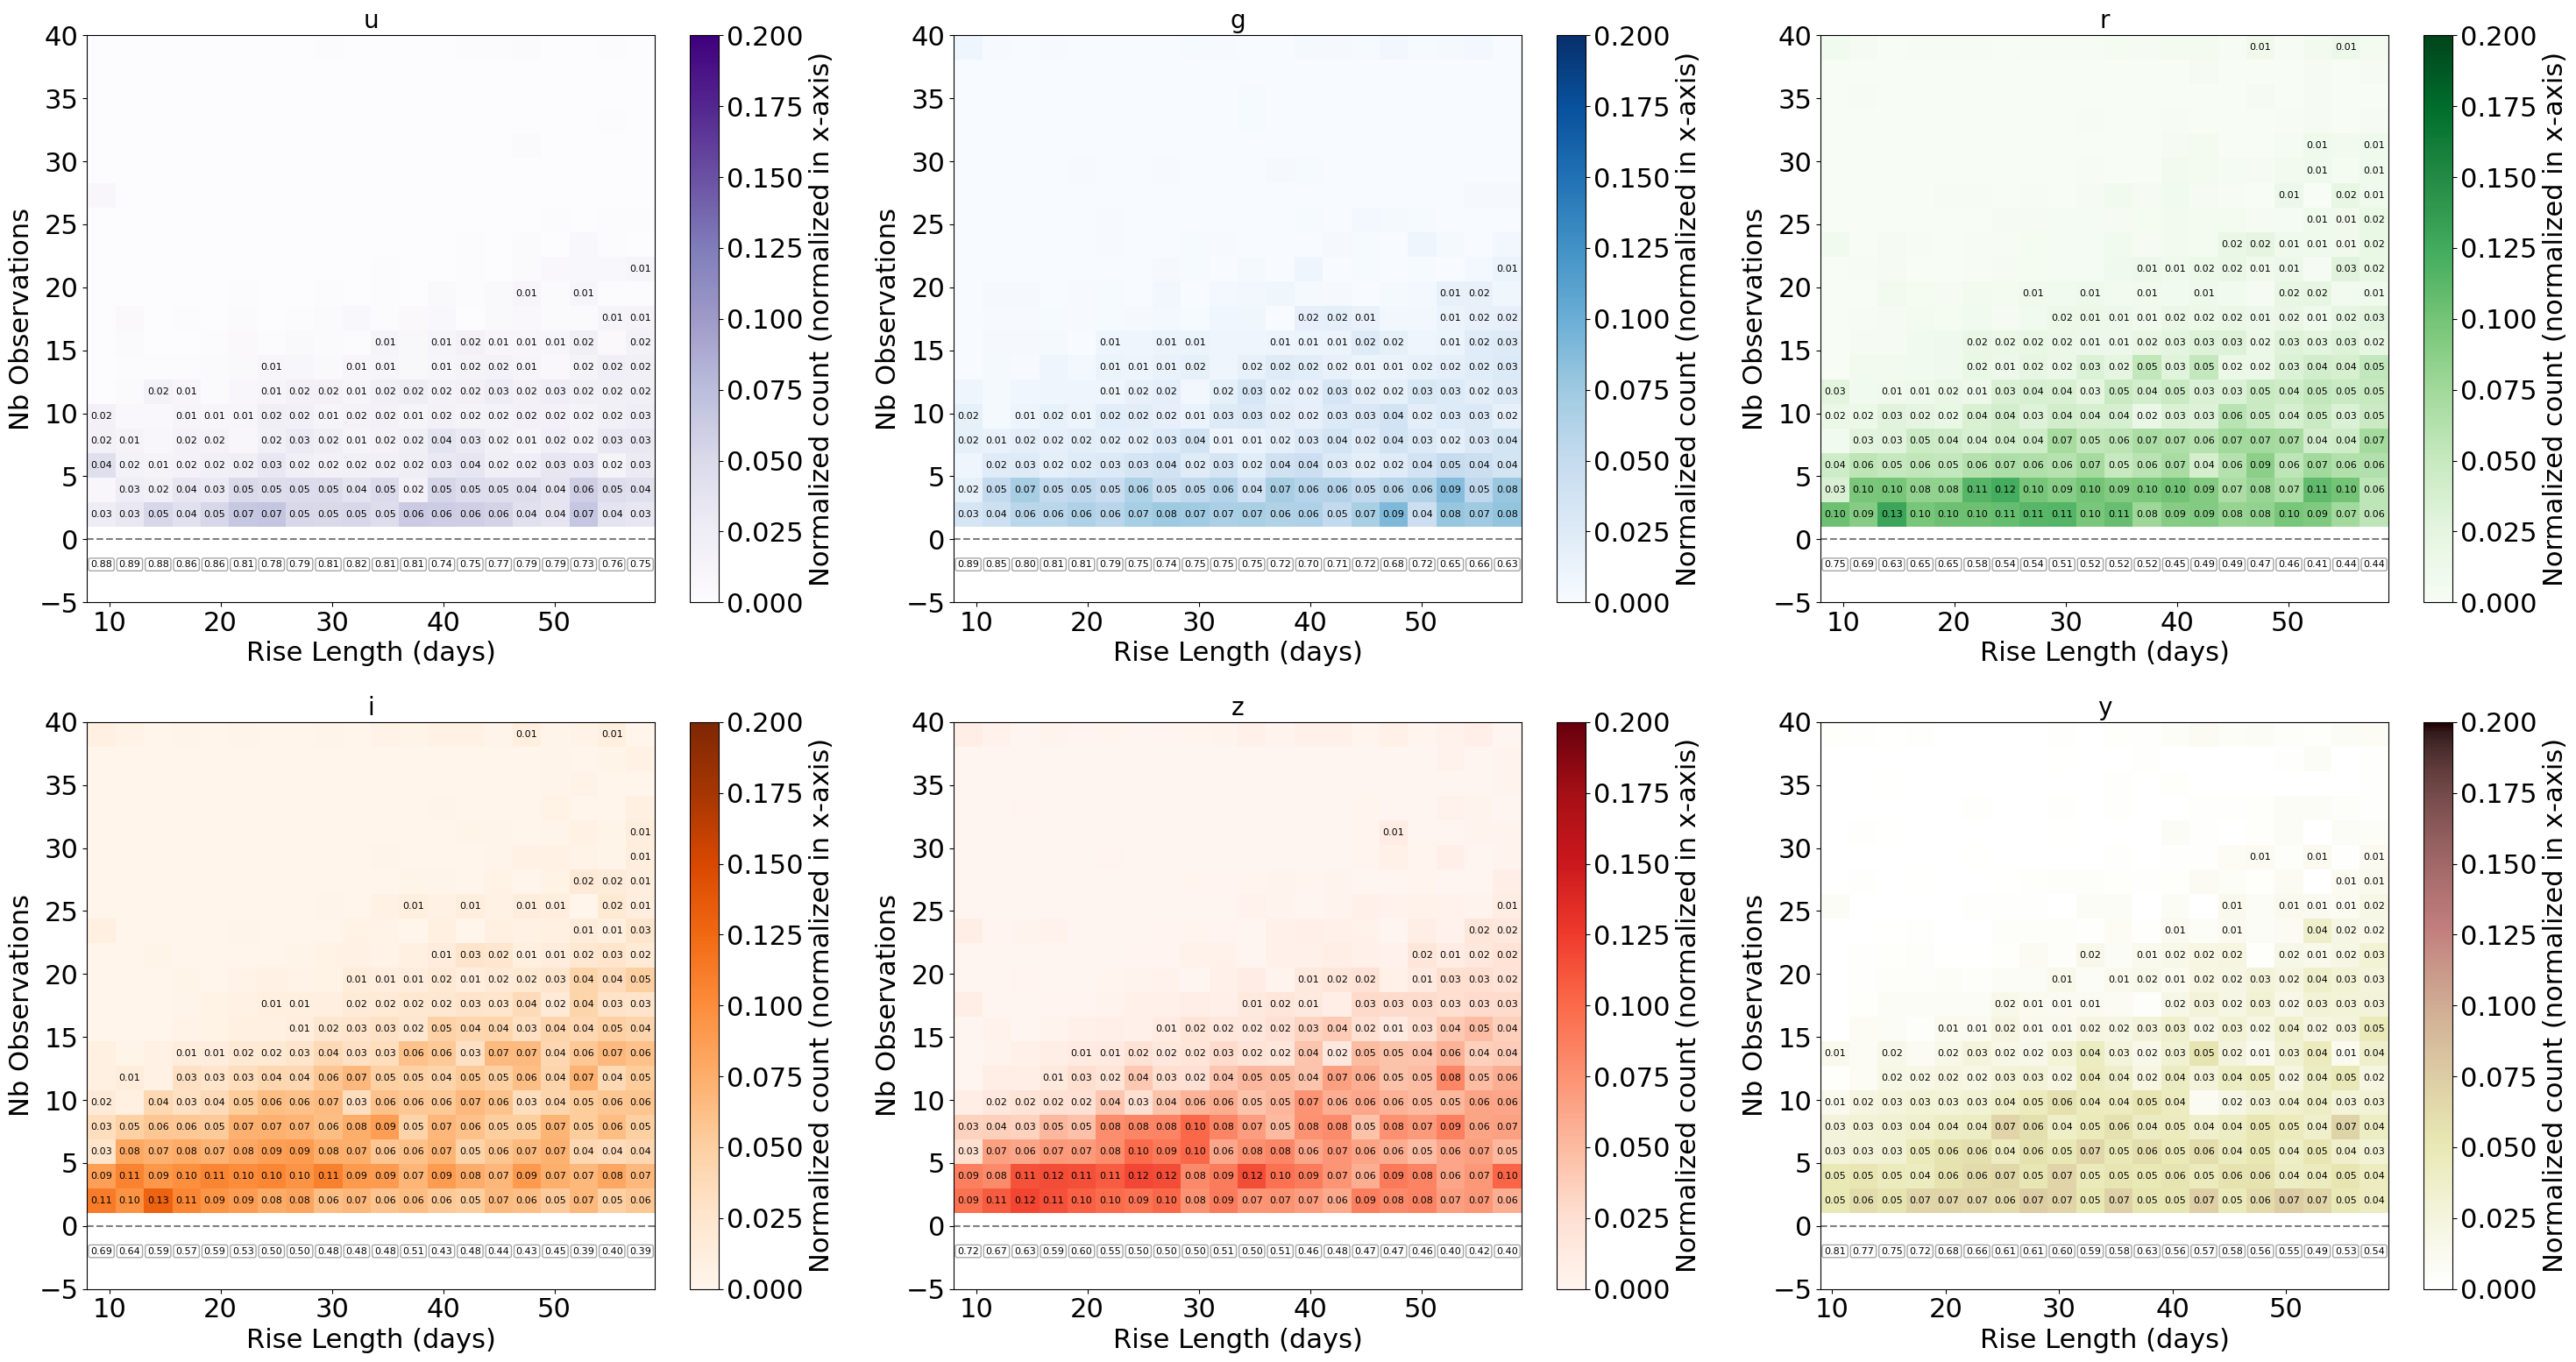

In [64]:
band_list_cln = ['u','g','r','i','z','y']
#Greys, Purples, Blues, Greens, Oranges, Reds, YlOrBr, RdPu, BuPu,YlGn
#u = purple, g=blue, r=green, i=orange, z= red, y= brown
cmaps = [cm.Purples, cm.Blues, cm.Greens, cm.Oranges, cm.Reds, cm.pink_r]
matplotlib.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(2, 3, figsize=(10*3, 8*2))


## Should I cap nbobsrises at max values to not lose ?
maxobs = 40
maxrise = 60
nb_x_bin = 20
nb_y_bin = 20

nbobsrises[np.where(nbobsrises>=maxobs)] = maxobs

for b in range(len(band_list_cln)):
    
    # Modified mask to include y==0 cases for counting but separate them
    mask_nonzero = (nbrisesday[:,b] < maxrise) & (nbobsrises[:,b] <= maxobs) & (nbobsrises[:,b] > 0)
    mask_zero = (nbrisesday[:,b] < maxrise) & (nbobsrises[:,b] == 0)
    
    # Data for plotting and coloring (y > 0)
    x_nonzero = nbrisesday[:,b][mask_nonzero]
    y_nonzero = nbobsrises[:,b][mask_nonzero]
    
    # Data for zero cases (y == 0)
    x_zero = nbrisesday[:,b][mask_zero]
    y_zero = nbobsrises[:,b][mask_zero]
    

    
    # Create the regular 2D histogram for colored visualization (y > 0)
    hist_nonzero, x_edges, y_edges = np.histogram2d(x_nonzero, y_nonzero, bins=(nb_x_bin, nb_y_bin))
    
    # Create histogram for y==0 cases
    hist_zero, x_edges_zero = np.histogram(x_zero, bins=x_edges)

    
     ## For the NUMBER PRINT we want to include the zeros 
    # Calculate the sum for each x-bin (column) including zero bins for normalization
    x_bin_sums = np.sum(hist_nonzero, axis=1)  # Sum over y values for each x bin
    for i in range(len(hist_zero)):
        x_bin_sums[i] += hist_zero[i]
    
    epsilon = 1e-10
    x_bin_sums[np.where(x_bin_sums == 0)[0]] = epsilon 
    
    # Normalize
    normalized_hist_w0 = np.array([hist_nonzero[i,:]/x_bin_sums[i] for i in range(nb_x_bin)])
    
    normalized_hist_zero = np.array([hist_zero[i]/x_bin_sums[i] for i in range(nb_x_bin)])
 
    ax = axs[int(b/3), b%3]
    
    # Plot the normalized 2D histogram (only for non-zero y values)
    pcm = ax.pcolormesh(x_edges, y_edges, normalized_hist_w0.T, 
                        cmap=cmaps[b], vmin=0, vmax=.2)
    
    # Add a colorbar
    cbar = fig.colorbar(pcm, ax=ax, label='Normalized count (normalized in x-axis)')
    
    # Add the count numbers to each cell (for y > 0)
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2

      
    # Add text for counts in each cell (y > 0)
    for i in range(len(x_centers)):
        for j in range(len(y_centers)):
            # count = int(hist_nonzero[i, j])
            # if count > 0:  # Only add text for non-empty bins
            #     color = 'white' if normalized_hist[i, j] > 0.5 else 'black'
            #     ax.text(x_centers[i], y_centers[j], str(count), 
            #             ha='center', va='center', color=color, fontsize=8)
            count = normalized_hist_w0[i,j] #int(hist[i, j])
            if count > 0.01:  # Only add text for non-empty bins
                # Choose text color based on background color (dark for light backgrounds, light for dark backgrounds)
                color = 'black'# 'white' if normalized_hist[i, j] > 0.5 else 'black'
                ax.text(x_centers[i], y_centers[j], "{:.2f}".format(normalized_hist_w0[i,j]), 
                        ha='center', va='center', color=color, fontsize=8)
    
    # Add an extra row for y==0 cases (not colored but showing counts)
    y_zero_pos = -2  # Position below the y-axis start for visibility
    
    # Add a dashed line to separate the y==0 row
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)

    # Display counts for y==0 bins
    for i in range(len(x_centers)):
        count = normalized_hist_zero[i] #int(hist_zero[i])
        if count > 0:
            ax.text(x_centers[i], y_zero_pos, "{:.2f}".format(normalized_hist_zero[i]), 
                    ha='center', va='center', color='black', fontsize=8, 
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round,pad=0.2'))
    
    # Add a label for the y==0 row
    #ax.text(x_edges[0] - 5, y_zero_pos, "y=0", ha='right', va='center', fontsize=12)
    
    
    # Add labels and title
    ax.set_xlabel('Rise Length (days)')
    ax.set_ylabel('Nb Observations')
    ax.set_title(band_list_cln[b], fontsize=20)
    
    # Adjust y-axis to make room for the y==0 row
    ax.set_ylim(y_zero_pos-3, ax.get_ylim()[1])

plt.tight_layout()
plt.savefig("fraction_observed_riselengths.pdf", dpi=50)
plt.show()

## Check color at peaks

In [ ]:
## For all MOSFIT, get peak magnitude for all band, and compute color_diff.
## Do it at peak, peak - 5days, peak + 10days, peak+30 days




In [23]:
def get_pkmags_offsetdays(json_file, days_off_peakday=[-5,0,10,30]):

    
    ## So I pick a lightcurve, and put it somewhere on the sky
    band_list_cln = ['u','g','r','i','z','y']
    
    
    #print(tmin, tmax)
    with open(json_file, 'r', encoding = 'utf-8') as f:
        data = json.loads(f.read())
        if 'name' not in data:
            data = data[list(data.keys())[0]]
    
    photo = data['photometry']
    model = data['models'][0]
    
    band_attr = ['band', 'instrument', 'telescope', 'system', 'bandset']
    band_list2 = list(set([tuple(x.get(y, '')
                                for y in band_attr) for x in photo
                                if 'band' in x and 'magnitude' in x]))
    
    ## 
    ## TODO Check how many real we got for all the TDEs generated, is it always...2?
    realiza = []
    for x in photo:
        realiza.append(x['realization'])
    realiza = np.unique(realiza)
    
    rea = realiza[0] ## 
    
    times = {b:[] for b in band_list_cln} # 
    truemagsMOS = {b:[] for b in band_list_cln}
    
    for x in photo:
        if x['realization']==rea:
            times[x['band']].append(float(x['time']))
            truemagsMOS[x['band']].append(float(x['magnitude']))
            
    mags_offpk = {b:[] for b in band_list_cln} # 
    times_offpk = {b:[] for b in band_list_cln} # 
    for b in band_list_cln:
        times[b] = np.arange(len(times[b])) # This is to deal with the slightly off issue?
        pkday = np.argmin(truemagsMOS[b]) #peak_day = times[b][np.argmin(truemagsMOS[b])]
        for d in days_off_peakday:
            mags_offpk[b].append(truemagsMOS[b][pkday+d])
            times_offpk[b].append(times[b][pkday+d])

    return mags_offpk, times_offpk


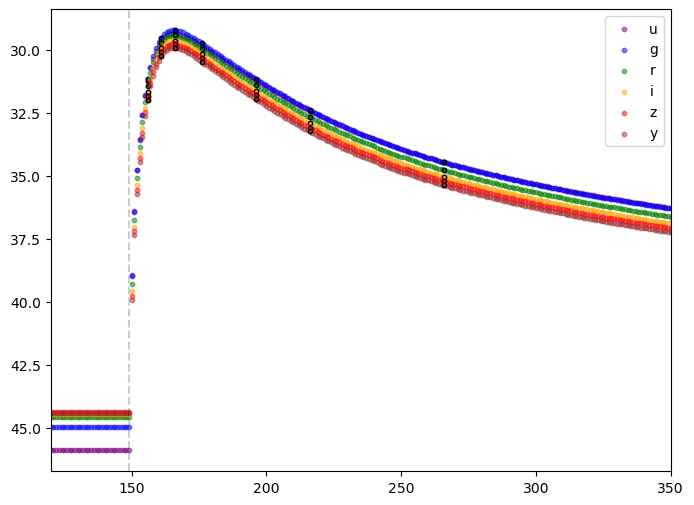

In [35]:
band_list_cln = ['u','g','r','i','z','y']
colors = {'u':'purple', 'g':'b', 'r':'g', 'i':'orange', 'z':'r', 'y':'brown'}

#Greys, Purples, Blues, Greens, Oranges, Reds, YlOrBr, RdPu, BuPu,YlGn
#u = purple, g=blue, r=green, i=orange, z= red, y= brown
#cmaps = [cm.Purples, cm.Blues, cm.Greens, cm.Oranges, cm.Reds, cm.pink_r]
    
json_file = f"/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_{5}.json"
reas = get_MOSIFT_reals_errors_addnoise(json_file, shave_time=0)
pkmags, timespk = get_pkmags_offsetdays(json_file, days_off_peakday=[-10, -5,0,10,30, 50, 100])

k = list(reas.keys())[0]
    
plt.figure(figsize=(8,6))
for b in band_list_cln:#, 'r']:
    #plt.errorbar(reas[k]['time'], reas[k]['mags'][b], yerr=reas[k]['e_mags'][b], label=b, alpha=.3)
    plt.scatter(reas[k]['time'], reas[k]['mags'][b], label=b, s=10, alpha=.5, c=colors[b])
    plt.scatter(timespk[b], pkmags[b], c=colors[b], edgecolors='k', s=10, alpha=1)
    

    
plt.legend()
plt.gca().invert_yaxis()
plt.xlim(120,350)

plt.axvline(149, color='k', ls='--', alpha=.2)
plt.show()

In [38]:
df_tdes_pkmag = pd.DataFrame(df_tdes)
daysoff = [-10, -5,0,10,30, 50, 100]
for b in band_list_cln:
    for d in daysoff:
        df_tdes_pkmag[f"{b}_{d}_mag"] = np.nan
        df_tdes_pkmag[f"{b}_{d}_t"] = np.nan
df_tdes_pkmag

Unnamed: 0       bhmass  stellar_mass  scaled_b  redshift    label  \
0               0     100000.0           0.3       0.0      0.01      0.0   
1               1     100000.0           0.3       0.0      0.12      1.0   
2               2     100000.0           0.3       0.0      0.23      2.0   
3               3     100000.0           0.3       0.0      0.34      3.0   
4               4     100000.0           0.3       0.0      0.45      4.0   
...           ...          ...           ...       ...       ...      ...   
23995       23995  100000000.0           1.0       2.0      0.56  23995.0   
23996       23996  100000000.0           1.0       2.0      0.67  23996.0   
23997       23997  100000000.0           1.0       2.0      0.78  23997.0   
23998       23998  100000000.0           1.0       2.0      0.89  23998.0   
23999       23999  100000000.0           1.0       2.0      1.00  23999.0   

       u_-10_mag  u_-10_t  u_-5_mag  u_-5_t  ...  y_0_mag  y_0_t  y_10_mag  \
0            NaN      NaN       NaN     NaN  ...      NaN    NaN       NaN   
1            NaN      NaN       NaN     NaN  ...      NaN    NaN       NaN   
2            NaN      NaN       NaN     NaN  ...      NaN    NaN       NaN   
3            NaN      NaN       NaN     NaN  ...      NaN    NaN       NaN   
4            NaN      NaN       NaN     NaN  ...      NaN    NaN       NaN   
...          ...      ...       ...     ...  ...      ...    ...       ...   
23995        NaN      NaN       NaN     NaN  ...      NaN    NaN       NaN   
23996        NaN      NaN       NaN     NaN  ...      NaN    NaN       NaN   
23997        NaN      NaN       NaN     NaN  ...      NaN    NaN       NaN   
23998        NaN      NaN       NaN     NaN  ...      NaN    NaN       NaN   
23999        NaN      NaN       NaN     NaN  ...      NaN    NaN       NaN   

       y_10_t  y_30_mag  y_30_t  y_50_mag  y_50_t  y_100_mag  y_100_t  
0         NaN       NaN     NaN       NaN     NaN        NaN      NaN  
1         NaN       NaN     NaN       NaN     NaN        NaN      NaN  
2         NaN       NaN     NaN       NaN     NaN        NaN      NaN  
3         NaN       NaN     NaN       NaN     NaN        NaN      NaN  
4         NaN       NaN     NaN       NaN     NaN        NaN      NaN  
...       ...       ...     ...       ...     ...        ...      ...  
23995     NaN       NaN     NaN       NaN     NaN        NaN      NaN  
23996     NaN       NaN     NaN       NaN     NaN        NaN      NaN  
23997     NaN       NaN     NaN       NaN     NaN        NaN      NaN  
23998     NaN       NaN     NaN       NaN     NaN        NaN      NaN  
23999     NaN       NaN     NaN       NaN     NaN        NaN      NaN  

[24000 rows x 90 columns]

In [42]:

#pkmags_, timespk_ = {b:[] for b in band_list_cln},  {b:[] for b in band_list_cln}
reals = []

dir_lsst = "/d6/CAC/gcontardo/Data/MOSFITS_synth/apr13/lsst_synth_mosfitnoise_shavedT120/"
for i in range(len(df_tdes)):
    json_Tde = f"/d6/CAC/gcontardo/Data/MOSFITS_synth/feb13/products/tde_{int(df_tdes["label"].iloc[i])}.json"
    
    try:
        
        reas = get_MOSIFT_reals_errors_addnoise(json_Tde, shave_time=0)
        reals.append(reas[list(reas.keys())[0]])
        
        pkmags, timespk = get_pkmags_offsetdays(json_Tde, days_off_peakday=daysoff)
        for b in band_list_cln:
            for di in range(len(daysoff)):
                d = daysoff[di]
                df_tdes_pkmag[f"{b}_{d}_mag"].iloc[i] = pkmags[b][di]
                df_tdes_pkmag[f"{b}_{d}_t"].iloc[i] = timespk[b][di]
        
        
    except FileNotFoundError:
        print(f"{i} is missing?")

17 is missing?
1355 is missing?
1356 is missing?
1407 is missing?
1493 is missing?
2708 is missing?
3209 is missing?
3272 is missing?
3311 is missing?
3414 is missing?
3465 is missing?
3589 is missing?
3714 is missing?
4082 is missing?
4374 is missing?
4586 is missing?
4620 is missing?
5055 is missing?
5211 is missing?
5245 is missing?
5360 is missing?
5608 is missing?
5702 is missing?
6831 is missing?
7102 is missing?
7199 is missing?
7219 is missing?
7282 is missing?
7737 is missing?
8041 is missing?
8244 is missing?
8847 is missing?
9241 is missing?
9354 is missing?
10378 is missing?
10834 is missing?
10883 is missing?
11175 is missing?
11700 is missing?
12882 is missing?
12933 is missing?
13067 is missing?
13187 is missing?
13217 is missing?
13466 is missing?
13879 is missing?
15431 is missing?
16014 is missing?
16269 is missing?
16534 is missing?
16853 is missing?
17663 is missing?
17844 is missing?
17977 is missing?
18273 is missing?
18940 is missing?
19096 is missing?
19359 is m

In [43]:
df_tdes_pkmag

Unnamed: 0       bhmass  stellar_mass  scaled_b  redshift    label  \
0               0     100000.0           0.3       0.0      0.01      0.0   
1               1     100000.0           0.3       0.0      0.12      1.0   
2               2     100000.0           0.3       0.0      0.23      2.0   
3               3     100000.0           0.3       0.0      0.34      3.0   
4               4     100000.0           0.3       0.0      0.45      4.0   
...           ...          ...           ...       ...       ...      ...   
23995       23995  100000000.0           1.0       2.0      0.56  23995.0   
23996       23996  100000000.0           1.0       2.0      0.67  23996.0   
23997       23997  100000000.0           1.0       2.0      0.78  23997.0   
23998       23998  100000000.0           1.0       2.0      0.89  23998.0   
23999       23999  100000000.0           1.0       2.0      1.00  23999.0   

       u_-10_mag  u_-10_t   u_-5_mag  u_-5_t  ...    y_0_mag  y_0_t  \
0      29.979781    150.0  21.569904   155.0  ...  21.607082  160.0   
1      32.231428    151.0  26.710720   156.0  ...  26.902176  161.0   
2      32.004408    152.0  27.938869   157.0  ...  28.232963  162.0   
3      31.813094    153.0  28.675106   158.0  ...  28.999509  163.0   
4      31.765284    154.0  29.268469   159.0  ...  29.521596  164.0   
...          ...      ...        ...     ...  ...        ...    ...   
23995  21.286345    566.0  21.285216   571.0  ...  21.512995  576.0   
23996  21.781717    596.0  21.780762   601.0  ...  21.836652  606.0   
23997  22.059217    626.0  22.058386   631.0  ...  22.110912  636.0   
23998  22.213310    656.0  22.212576   661.0  ...  22.349787  666.0   
23999  22.372387    686.0  22.371732   691.0  ...  22.559387  696.0   

        y_10_mag  y_10_t   y_30_mag  y_30_t   y_50_mag  y_50_t  y_100_mag  \
0      22.559520   170.0  24.732215   190.0  26.296860   210.0  28.468280   
1      27.720931   171.0  29.719185   191.0  31.245404   211.0  33.424172   
2      28.941242   172.0  30.788627   192.0  32.262790   212.0  34.447366   
3      29.615915   173.0  31.330012   193.0  32.748059   213.0  34.932178   
4      30.060901   174.0  31.654869   194.0  33.017306   214.0  35.193406   
...          ...     ...        ...     ...        ...     ...        ...   
23995  21.514581   586.0  21.529960   606.0  21.560412   626.0  21.693986   
23996  21.838022   616.0  21.851213   636.0  21.877661   656.0  21.994704   
23997  22.112097   646.0  22.123463   666.0  22.146749   686.0  22.249806   
23998  22.350811   676.0  22.360749   696.0  22.381181   716.0  22.472708   
23999  22.560270   706.0  22.569087   726.0  22.587168   746.0  22.668667   

       y_100_t  
0        260.0  
1        261.0  
2        262.0  
3        263.0  
4        264.0  
...        ...  
23995    676.0  
23996    706.0  
23997    736.0  
23998    766.0  
23999    796.0  

[24000 rows x 90 columns]

Text(0, 0.5, 'i_0_mag - u_0_mag')

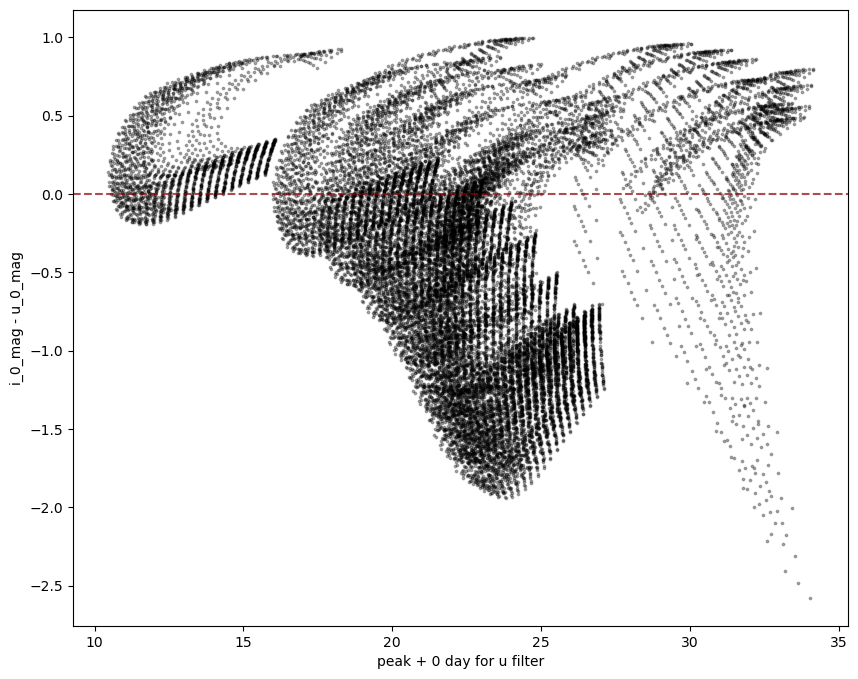

In [47]:
### We want to plot....  i-u vs peak u, g-r vs peak ? g, i-u vs g-r at peak and at different time

plt.figure(figsize=(10,8))

da = 0
b1,b2 = 'i','u'
key1, key2 = f"{b1}_{da}_mag", f"{b2}_{da}_mag"
b3,b4  ='g','r'
key3, key4 = f"{b3}_{da}_mag", f"{b3}_{da}_mag"

ys = df_tdes_pkmag[key1] - df_tdes_pkmag[key2]
xs = df_tdes_pkmag[key2]

plt.scatter(xs, ys, s=3, c='k', alpha=.3, rasterized=True)

plt.axhline(0, color='darkred', ls='--', alpha=.7)
plt.xlabel(f"peak + {da} day for {b2} filter")
plt.ylabel(f"{key1} - {key2}")

Text(0, 0.5, 'g_0_mag - r_0_mag')

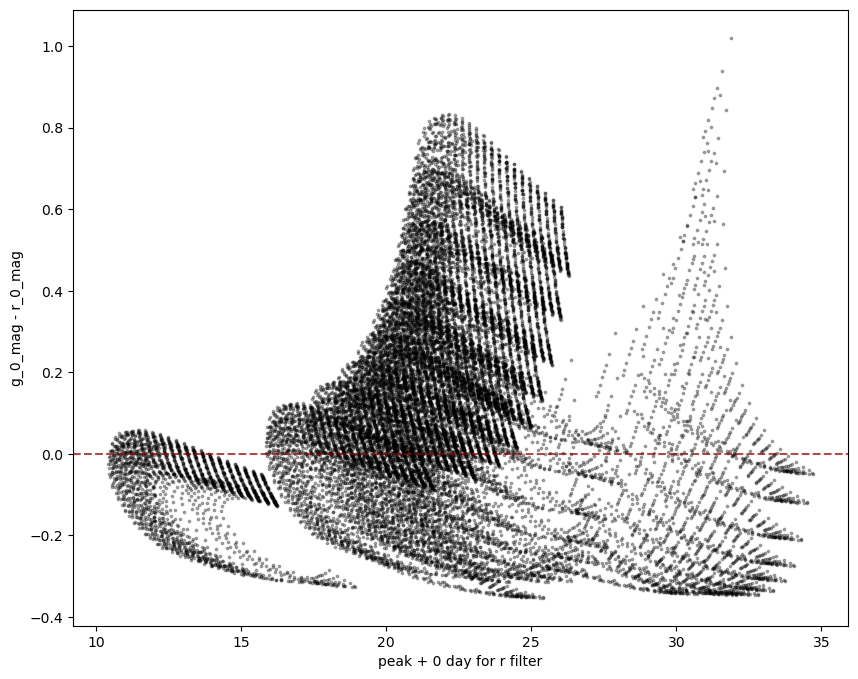

In [49]:
### We want to plot....  i-u vs peak u, g-r vs peak ? g, i-u vs g-r at peak and at different time

plt.figure(figsize=(10,8))

da = 0
b1,b2 = 'i','u'
key1, key2 = f"{b1}_{da}_mag", f"{b2}_{da}_mag"
b3,b4  ='g','r'
key3, key4 = f"{b3}_{da}_mag", f"{b4}_{da}_mag"

ys = df_tdes_pkmag[key3] - df_tdes_pkmag[key4]
xs = df_tdes_pkmag[key4]

plt.scatter(xs, ys, s=3, c='k', alpha=.3, rasterized=True)

plt.axhline(0, color='darkred', ls='--', alpha=.7)
plt.xlabel(f"peak + {da} day for {b4} filter")
plt.ylabel(f"{key3} - {key4}")